# Notebook 02i : Transformer Combined
## Dropout + Bruit Gaussien + Feasibility + Clustering Hiérarchique 

Ce notebook combine toutes les améliorations des notebooks précédents :

1. **Spike dropout (15%)** + **Bruit gaussien (std=0.5)** sur les waveforms (02d)
2. **Feasibility loss** : pénalise les prédictions hors du couloir du U-maze (02d_bis)
3. **Classification hiérarchique 3 zones** + régression conditionnelle (02h)
4. **5-fold cross-validation**, 30 epochs max, early stopping patience=7

**Architecture** : SpikeTransformerHierarchical
- Backbone partagé (CNN encoders + Transformer 2 layers)
- Classification 3 zones (gauche / haut / droite)
- 3 heads de régression conditionnelle (mu + sigma par zone)
- Prédiction de distance curviligne d (tâche auxiliaire)
- Mélange pondéré par softmax pour la prédiction finale

**Loss combinée** :
```
L = CrossEntropy(zone) + Σ GaussianNLL(par zone, masqué) + λ_d * MSE(d) + λ_feas * Feasibility
```

## 1. Imports et configuration

In [1]:
import pandas as pd
import numpy as np
import json
import os
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

# Reproductibilité
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')
print(f'Device: {DEVICE}')

Device: cuda


## 2. Chargement des données

In [2]:
LOCAL_DIR = os.path.join(os.path.abspath('..'), 'data')

PARQUET_NAME = "M1199_PAG_stride4_win108_test.parquet"
JSON_NAME = "M1199_PAG.json"

PARQUET_FILE = os.path.join(LOCAL_DIR, PARQUET_NAME)
JSON_FILE = os.path.join(LOCAL_DIR, JSON_NAME)

if not os.path.exists(PARQUET_FILE):
    raise FileNotFoundError(
        f"Données introuvables dans {LOCAL_DIR}/\n"
        f"Lancez d'abord: python download_data.py"
    )

print(f"Chargement depuis {LOCAL_DIR}/")
df = pd.read_parquet(PARQUET_FILE)
with open(JSON_FILE, "r") as f:
    params = json.load(f)

print(f"Shape: {df.shape}")

nGroups = params['nGroups']
nChannelsPerGroup = [params[f'group{g}']['nChannels'] for g in range(nGroups)]
print(f"nGroups={nGroups}, nChannelsPerGroup={nChannelsPerGroup}")

# Filtrage speedMask
speed_masks = np.array([x[0] for x in df['speedMask']])
df_moving = df[speed_masks].reset_index(drop=True)
print(f'Exemples en mouvement : {len(df_moving)}')

Chargement depuis /home/onyxia/work/hacktion-potential/data/
Shape: (62257, 18)
nGroups=4, nChannelsPerGroup=[6, 4, 6, 4]
Exemples en mouvement : 22974


## 3. Géométrie du U-maze, distance curviligne et labels de zone

**Squelette central** : 3 segments formant un U
1. (0.15, 0) → (0.15, 0.85) — bras gauche
2. (0.15, 0.85) → (0.85, 0.85) — couloir haut
3. (0.85, 0.85) → (0.85, 0) — bras droit

**3 zones** basées sur la distance curviligne d :
- Gauche (classe 0) : d < 0.354
- Haut (classe 1) : 0.354 ≤ d < 0.646
- Droite (classe 2) : d ≥ 0.646

In [3]:
# --- Squelette du U ---
SKELETON_SEGMENTS = np.array([
    [0.15, 0.0, 0.15, 0.85],   # Segment 1 : bras gauche (bas → haut)
    [0.15, 0.85, 0.85, 0.85],  # Segment 2 : couloir haut (gauche → droite)
    [0.85, 0.85, 0.85, 0.0],   # Segment 3 : bras droit (haut → bas)
])

CORRIDOR_HALF_WIDTH = 0.15

SEGMENT_LENGTHS = np.array([
    np.sqrt((s[2]-s[0])**2 + (s[3]-s[1])**2) for s in SKELETON_SEGMENTS
])
TOTAL_LENGTH = SEGMENT_LENGTHS.sum()  # 2.40
CUMULATIVE_LENGTHS = np.concatenate([[0], np.cumsum(SEGMENT_LENGTHS)])

# Seuils de zone
D_LEFT_END = CUMULATIVE_LENGTHS[1] / TOTAL_LENGTH    # ≈ 0.354
D_RIGHT_START = CUMULATIVE_LENGTHS[2] / TOTAL_LENGTH  # ≈ 0.646

N_ZONES = 3
ZONE_NAMES = ['Gauche', 'Haut', 'Droite']

print(f'Longueurs des segments : {SEGMENT_LENGTHS}')
print(f'Longueur totale du U : {TOTAL_LENGTH:.2f}')
print(f'Seuils : Gauche d<{D_LEFT_END:.4f}, Haut {D_LEFT_END:.4f}-{D_RIGHT_START:.4f}, Droite d>={D_RIGHT_START:.4f}')


def project_point_on_segment(px, py, x1, y1, x2, y2):
    """Projette un point (px, py) sur le segment [(x1,y1), (x2,y2)]."""
    dx, dy = x2 - x1, y2 - y1
    seg_len_sq = dx**2 + dy**2
    if seg_len_sq < 1e-12:
        return 0.0, np.sqrt((px - x1)**2 + (py - y1)**2), x1, y1
    t = ((px - x1) * dx + (py - y1) * dy) / seg_len_sq
    t = np.clip(t, 0.0, 1.0)
    proj_x = x1 + t * dx
    proj_y = y1 + t * dy
    dist = np.sqrt((px - proj_x)**2 + (py - proj_y)**2)
    return t, dist, proj_x, proj_y


def compute_curvilinear_distance(x, y):
    """Distance curviligne normalisée d ∈ [0, 1] le long du U."""
    best_dist = np.inf
    best_d = 0.0
    for i, (x1, y1, x2, y2) in enumerate(SKELETON_SEGMENTS):
        t, dist, _, _ = project_point_on_segment(x, y, x1, y1, x2, y2)
        if dist < best_dist:
            best_dist = dist
            best_d = (CUMULATIVE_LENGTHS[i] + t * SEGMENT_LENGTHS[i]) / TOTAL_LENGTH
    return best_d


def compute_distance_to_skeleton(x, y):
    """Distance minimale du point (x, y) au squelette du U."""
    best_dist = np.inf
    for x1, y1, x2, y2 in SKELETON_SEGMENTS:
        _, dist, _, _ = project_point_on_segment(x, y, x1, y1, x2, y2)
        best_dist = min(best_dist, dist)
    return best_dist


def d_to_zone(d):
    """Convertit une distance curviligne d en label de zone (0, 1, 2)."""
    if d < D_LEFT_END:
        return 0
    elif d < D_RIGHT_START:
        return 1
    else:
        return 2


# --- Calcul de d et zone_labels pour tous les exemples ---
positions = np.array([[x[0], x[1]] for x in df_moving['pos']], dtype=np.float32)
curvilinear_d = np.array([
    compute_curvilinear_distance(x, y) for x, y in positions
], dtype=np.float32)
zone_labels = np.array([d_to_zone(d) for d in curvilinear_d], dtype=np.int64)

print(f'\nd curviligne : min={curvilinear_d.min():.4f}, max={curvilinear_d.max():.4f}, mean={curvilinear_d.mean():.4f}')
print(f'\nDistribution des zones :')
for z in range(N_ZONES):
    count = (zone_labels == z).sum()
    print(f'  {ZONE_NAMES[z]:8s} (classe {z}) : {count} ({count / len(zone_labels):.1%})')

dist_to_skel = np.array([compute_distance_to_skeleton(x, y) for x, y in positions])
print(f'\nDistance au squelette : mean={dist_to_skel.mean():.4f}, max={dist_to_skel.max():.4f}')
print(f'  % dans le couloir (dist < {CORRIDOR_HALF_WIDTH}) : {(dist_to_skel < CORRIDOR_HALF_WIDTH).mean():.1%}')

Longueurs des segments : [0.85 0.7  0.85]
Longueur totale du U : 2.40
Seuils : Gauche d<0.3542, Haut 0.3542-0.6458, Droite d>=0.6458

d curviligne : min=0.0000, max=1.0000, mean=0.4727

Distribution des zones :
  Gauche   (classe 0) : 8655 (37.7%)
  Haut     (classe 1) : 7851 (34.2%)
  Droite   (classe 2) : 6468 (28.2%)

Distance au squelette : mean=0.0725, max=0.1943
  % dans le couloir (dist < 0.15) : 95.3%


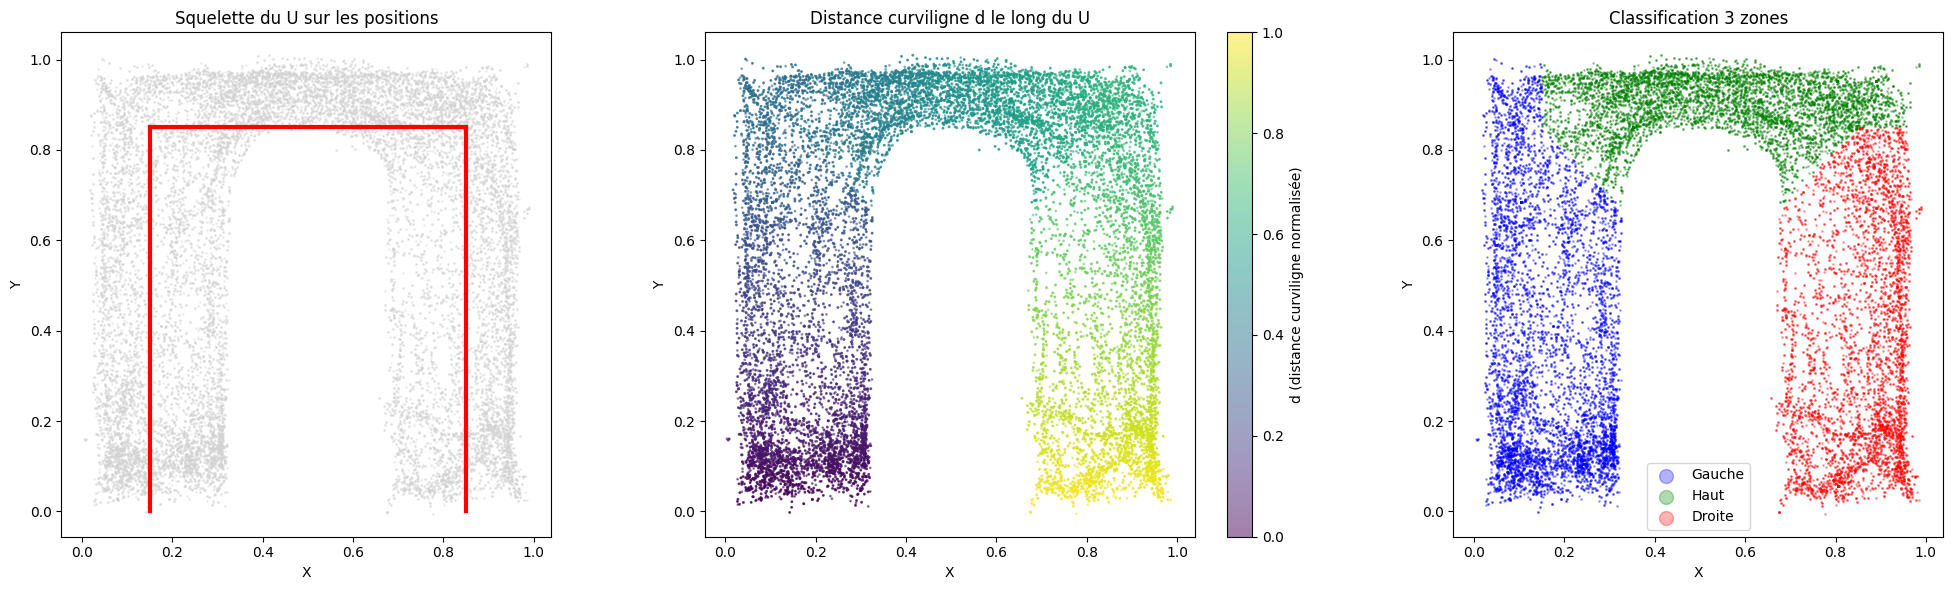

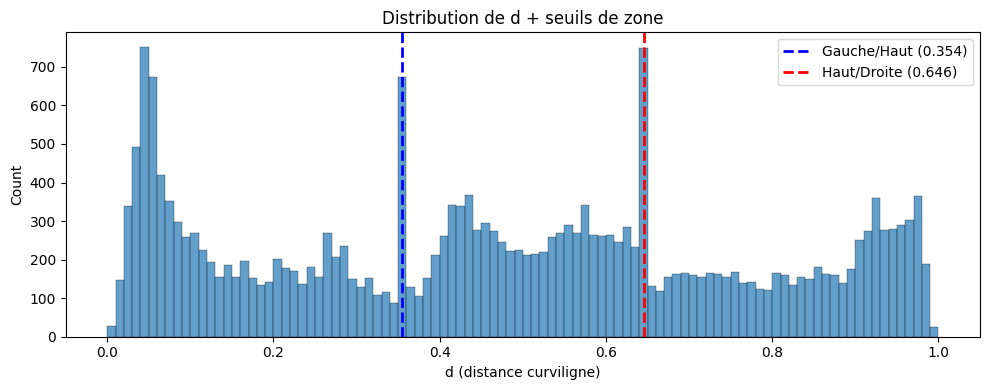

In [4]:
# --- Visualisation : d + classification 3 zones ---
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# 1. Squelette
axes[0].scatter(positions[:, 0], positions[:, 1], c='lightgray', s=1, alpha=0.3)
for x1, y1, x2, y2 in SKELETON_SEGMENTS:
    axes[0].plot([x1, x2], [y1, y2], 'r-', linewidth=3)
axes[0].set_xlabel('X'); axes[0].set_ylabel('Y')
axes[0].set_title('Squelette du U sur les positions')
axes[0].set_aspect('equal')

# 2. d coloré
sc = axes[1].scatter(positions[:, 0], positions[:, 1], c=curvilinear_d, s=1, alpha=0.5, cmap='viridis')
plt.colorbar(sc, ax=axes[1], label='d (distance curviligne normalisée)')
axes[1].set_xlabel('X'); axes[1].set_ylabel('Y')
axes[1].set_title('Distance curviligne d le long du U')
axes[1].set_aspect('equal')

# 3. Classification 3 zones
zone_colors = ['blue', 'green', 'red']
for z in range(N_ZONES):
    mask_z = zone_labels == z
    axes[2].scatter(positions[mask_z, 0], positions[mask_z, 1], c=zone_colors[z], s=1, alpha=0.3, label=f'{ZONE_NAMES[z]}')
axes[2].set_xlabel('X'); axes[2].set_ylabel('Y')
axes[2].set_title(f'Classification 3 zones')
axes[2].legend(markerscale=10)
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

# Histogramme de d avec seuils
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(curvilinear_d, bins=100, alpha=0.7, edgecolor='black', linewidth=0.3)
ax.axvline(x=D_LEFT_END, color='blue', linestyle='--', linewidth=2, label=f'Gauche/Haut ({D_LEFT_END:.3f})')
ax.axvline(x=D_RIGHT_START, color='red', linestyle='--', linewidth=2, label=f'Haut/Droite ({D_RIGHT_START:.3f})')
ax.set_xlabel('d (distance curviligne)'); ax.set_ylabel('Count')
ax.set_title('Distribution de d + seuils de zone')
ax.legend()
plt.tight_layout()
plt.show()

## 4. Preprocessing : reconstruction de la séquence chronologique

In [5]:
def reconstruct_sequence(row, nGroups, nChannelsPerGroup, max_seq_len=128):
    """Reconstruit la séquence chronologique de spikes."""
    groups = row['groups']
    length = min(len(groups), max_seq_len)
    waveforms = {}
    for g in range(nGroups):
        nCh = nChannelsPerGroup[g]
        raw = row[f'group{g}']
        waveforms[g] = raw.reshape(-1, nCh, 32)
    seq_waveforms = []
    seq_shank_ids = []
    for t in range(length):
        g = int(groups[t])
        idx = int(row[f'indices{g}'][t])
        if idx > 0 and idx <= waveforms[g].shape[0]:
            seq_waveforms.append((waveforms[g][idx - 1], g))
            seq_shank_ids.append(g)
    return seq_waveforms, seq_shank_ids

wf, sids = reconstruct_sequence(df_moving.iloc[0], nGroups, nChannelsPerGroup)
print(f'Premier exemple : {len(wf)} spikes, shanks={set(sids)}')

Premier exemple : 78 spikes, shanks={0, 1, 2, 3}


## 5. Dataset PyTorch (avec zone_label et d curviligne)

In [6]:
MAX_SEQ_LEN = 128
MAX_CHANNELS = max(nChannelsPerGroup)  # 6

class SpikeSequenceDataset(Dataset):
    def __init__(self, dataframe, nGroups, nChannelsPerGroup, curvilinear_d, zone_labels, max_seq_len=MAX_SEQ_LEN):
        self.df = dataframe
        self.nGroups = nGroups
        self.nChannelsPerGroup = nChannelsPerGroup
        self.max_seq_len = max_seq_len
        self.targets = np.array([[x[0], x[1]] for x in dataframe['pos']], dtype=np.float32)
        self.curvilinear_d = curvilinear_d.astype(np.float32)
        self.zone_labels = zone_labels.astype(np.int64)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        seq, shank_ids = reconstruct_sequence(row, self.nGroups, self.nChannelsPerGroup, self.max_seq_len)
        seq_len = len(seq)
        if seq_len == 0:
            seq_len = 1
            waveforms = np.zeros((1, MAX_CHANNELS, 32), dtype=np.float32)
            shank_ids_arr = np.array([0], dtype=np.int64)
        else:
            waveforms = np.zeros((seq_len, MAX_CHANNELS, 32), dtype=np.float32)
            shank_ids_arr = np.array(shank_ids, dtype=np.int64)
            for t, (wf, g) in enumerate(seq):
                nCh = wf.shape[0]
                waveforms[t, :nCh, :] = wf
        return {
            'waveforms': torch.from_numpy(waveforms),
            'shank_ids': torch.from_numpy(shank_ids_arr),
            'seq_len': seq_len,
            'target': torch.from_numpy(self.targets[idx]),
            'd': torch.tensor(self.curvilinear_d[idx], dtype=torch.float32),
            'zone': torch.tensor(self.zone_labels[idx], dtype=torch.long)
        }


def collate_fn(batch):
    max_len = max(item['seq_len'] for item in batch)
    batch_size = len(batch)
    waveforms = torch.zeros(batch_size, max_len, MAX_CHANNELS, 32)
    shank_ids = torch.zeros(batch_size, max_len, dtype=torch.long)
    mask = torch.ones(batch_size, max_len, dtype=torch.bool)
    targets = torch.stack([item['target'] for item in batch])
    d_targets = torch.stack([item['d'] for item in batch])
    zone_targets = torch.stack([item['zone'] for item in batch])
    for i, item in enumerate(batch):
        sl = item['seq_len']
        waveforms[i, :sl] = item['waveforms']
        shank_ids[i, :sl] = item['shank_ids']
        mask[i, :sl] = False
    return {
        'waveforms': waveforms, 'shank_ids': shank_ids, 'mask': mask,
        'targets': targets, 'd_targets': d_targets, 'zone_targets': zone_targets
    }

print('Dataset et collate_fn définis.')

Dataset et collate_fn définis.


## 6. Feasibility Loss

Pénalise les prédictions (x, y) hors du couloir du U. Distance différentiable au squelette :
- `penalty = ReLU(distance - corridor_half_width)²`
- Nulle dans le couloir, quadratique au-delà

In [7]:
class FeasibilityLoss(nn.Module):
    """Pénalise les prédictions (x, y) qui tombent hors du couloir du U."""
    
    def __init__(self, skeleton_segments, corridor_half_width):
        super().__init__()
        self.register_buffer('segments', torch.tensor(skeleton_segments, dtype=torch.float32))
        self.corridor_half_width = corridor_half_width
    
    def forward(self, xy_pred):
        px, py = xy_pred[:, 0], xy_pred[:, 1]
        distances = []
        for i in range(self.segments.shape[0]):
            x1, y1, x2, y2 = self.segments[i]
            dx, dy = x2 - x1, y2 - y1
            seg_len_sq = dx**2 + dy**2
            t = ((px - x1) * dx + (py - y1) * dy) / (seg_len_sq + 1e-8)
            t = t.clamp(0.0, 1.0)
            proj_x, proj_y = x1 + t * dx, y1 + t * dy
            dist = torch.sqrt((px - proj_x)**2 + (py - proj_y)**2 + 1e-8)
            distances.append(dist)
        distances = torch.stack(distances, dim=1)
        min_dist = distances.min(dim=1).values
        return torch.relu(min_dist - self.corridor_half_width).pow(2).mean()


# Test
feas_loss = FeasibilityLoss(SKELETON_SEGMENTS, CORRIDOR_HALF_WIDTH)
in_corridor = torch.tensor([[0.15, 0.5], [0.85, 0.3], [0.5, 0.85]], dtype=torch.float32)
outside = torch.tensor([[0.5, 0.3], [0.5, 0.5], [0.5, 0.0]], dtype=torch.float32)
print(f'Pénalité (dans le couloir) : {feas_loss(in_corridor).item():.6f}')
print(f'Pénalité (hors couloir)    : {feas_loss(outside).item():.6f}')

Pénalité (dans le couloir) : 0.000000
Pénalité (hors couloir)    : 0.040000


## 7. Architecture du modèle

**SpikeTransformerHierarchical** avec :
- Spike dropout (15%) + Gaussian noise (std=0.5) en data augmentation
- Backbone partagé : CNN encoders par shank + Transformer 2 layers
- Classification 3 zones (softmax)
- 3 heads de régression conditionnelle (mu + log_sigma par zone)
- Head de distance curviligne d (Sigmoid)
- Mélange pondéré à l'inférence

In [8]:
class SpikeEncoder(nn.Module):
    def __init__(self, n_channels, embed_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=5, padding=2), nn.ReLU(),
            nn.Conv1d(32, embed_dim, kernel_size=3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
    def forward(self, x):
        return self.conv(x).squeeze(-1)


class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=256):
        super().__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class SpikeTransformerHierarchical(nn.Module):
    """Transformer hiérarchique : classification 3 zones + régression conditionnelle.
    Avec spike dropout et bruit gaussien en data augmentation."""
    
    def __init__(self, nGroups, nChannelsPerGroup, n_zones=3, embed_dim=64, nhead=4,
                 num_layers=2, dropout=0.2, spike_dropout=0.15, noise_std=0.5,
                 max_channels=MAX_CHANNELS):
        super().__init__()
        self.nGroups = nGroups
        self.embed_dim = embed_dim
        self.n_zones = n_zones
        self.max_channels = max_channels
        self.spike_dropout = spike_dropout
        self.noise_std = noise_std
        
        self.spike_encoders = nn.ModuleList([
            SpikeEncoder(max_channels, embed_dim) for _ in range(nGroups)
        ])
        self.shank_embedding = nn.Embedding(nGroups, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=nhead, dim_feedforward=embed_dim * 4,
            dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers, enable_nested_tensor=False
        )
        
        # Classification 3 zones
        self.cls_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(embed_dim, n_zones)
        )
        
        # Régression par zone
        self.mu_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(embed_dim, embed_dim), nn.ReLU(), nn.Dropout(dropout),
                nn.Linear(embed_dim, 2)
            ) for _ in range(n_zones)
        ])
        self.log_sigma_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(embed_dim, embed_dim), nn.ReLU(), nn.Dropout(dropout),
                nn.Linear(embed_dim, 2)
            ) for _ in range(n_zones)
        ])
        
        # Distance curviligne
        self.d_head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(embed_dim, 1), nn.Sigmoid()
        )
    
    def _apply_spike_dropout(self, mask):
        if not self.training or self.spike_dropout <= 0:
            return mask
        drop_mask = torch.rand_like(mask.float()) < self.spike_dropout
        active = ~mask
        new_drops = drop_mask & active
        remaining = active & ~new_drops
        all_dropped = remaining.sum(dim=1) == 0
        if all_dropped.any():
            new_drops[all_dropped] = False
        return mask | new_drops
    
    def _apply_waveform_noise(self, waveforms):
        if not self.training or self.noise_std <= 0:
            return waveforms
        return waveforms + torch.randn_like(waveforms) * self.noise_std
    
    def _encode(self, waveforms, shank_ids, mask):
        """Shared backbone : encode → transformer → pooling."""
        batch_size, seq_len = waveforms.shape[:2]
        mask = self._apply_spike_dropout(mask)
        waveforms = self._apply_waveform_noise(waveforms)
        
        embeddings = torch.zeros(batch_size, seq_len, self.embed_dim, device=waveforms.device)
        for g in range(self.nGroups):
            group_mask = (shank_ids == g) & (~mask)
            if group_mask.any():
                embeddings[group_mask] = self.spike_encoders[g](waveforms[group_mask])
        
        embeddings = embeddings + self.shank_embedding(shank_ids)
        embeddings = self.pos_encoding(embeddings)
        encoded = self.transformer(embeddings, src_key_padding_mask=mask)
        
        active_mask = (~mask).unsqueeze(-1).float()
        pooled = (encoded * active_mask).sum(dim=1) / (active_mask.sum(dim=1) + 1e-8)
        return pooled
    
    def forward(self, waveforms, shank_ids, mask):
        pooled = self._encode(waveforms, shank_ids, mask)
        cls_logits = self.cls_head(pooled)
        mus = [head(pooled) for head in self.mu_heads]
        sigmas = [torch.exp(head(pooled)) for head in self.log_sigma_heads]
        d_pred = self.d_head(pooled)
        return cls_logits, mus, sigmas, d_pred
    
    def predict(self, waveforms, shank_ids, mask):
        """Prédiction combinée via mélange pondéré par softmax."""
        cls_logits, mus, sigmas, d_pred = self.forward(waveforms, shank_ids, mask)
        probs = torch.softmax(cls_logits, dim=1)  # (batch, 3)
        
        mu_stack = torch.stack(mus, dim=1)       # (batch, 3, 2)
        sigma_stack = torch.stack(sigmas, dim=1)  # (batch, 3, 2)
        p = probs.unsqueeze(-1)                   # (batch, 3, 1)
        
        mu = (p * mu_stack).sum(dim=1)  # (batch, 2)
        var_combined = (p * (sigma_stack ** 2 + mu_stack ** 2)).sum(dim=1) - mu ** 2
        sigma = torch.sqrt(var_combined.clamp(min=1e-8))
        
        return mu, sigma, probs, d_pred


model = SpikeTransformerHierarchical(nGroups, nChannelsPerGroup)
n_params = sum(p.numel() for p in model.parameters())
print(f'Modèle créé : {n_params:,} paramètres')
print(f'Têtes : classification 3 zones + 3 régressions conditionnelles + d curviligne')

Modèle créé : 163,344 paramètres
Têtes : classification 3 zones + 3 régressions conditionnelles + d curviligne


## 8. Split et DataLoaders

In [9]:
# Split temporel 90/10
split_idx = int(len(df_moving) * 0.9)
df_train_full = df_moving.iloc[:split_idx].reset_index(drop=True)
df_test = df_moving.iloc[split_idx:].reset_index(drop=True)
d_train_full = curvilinear_d[:split_idx]
d_test = curvilinear_d[split_idx:]
zone_train_full = zone_labels[:split_idx]
zone_test = zone_labels[split_idx:]

print(f'Train : {len(df_train_full)} | Test : {len(df_test)}')
for z in range(N_ZONES):
    print(f'  {ZONE_NAMES[z]:8s} — train: {(zone_train_full == z).sum()}, test: {(zone_test == z).sum()}')

N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=41)
BATCH_SIZE = 64

test_dataset = SpikeSequenceDataset(df_test, nGroups, nChannelsPerGroup, d_test, zone_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)
print(f'Test: {len(test_dataset)} exemples, {len(test_loader)} batches')

Train : 20676 | Test : 2298
  Gauche   — train: 7804, test: 851
  Haut     — train: 6904, test: 947
  Droite   — train: 5968, test: 500
Test: 2298 exemples, 36 batches


## 9. Entraînement (5-Fold Cross-Validation, 30 epochs)

**Hyperparamètres** :
- embed_dim=64, nhead=4, 2 layers, dropout=0.2
- spike_dropout=15%, noise_std=0.5
- AdamW (lr=1e-3, weight_decay=1e-4)
- OneCycleLR, 30 epochs, patience=7

**Loss combinée** :
```
L = CrossEntropy(zone) + Σ GaussianNLL(par zone) + 1.0 * MSE(d) + 10.0 * Feasibility
```

In [10]:
# Hyperparamètres
EMBED_DIM = 64
NHEAD = 4
NUM_LAYERS = 2
DROPOUT = 0.2
SPIKE_DROPOUT = 0.15
NOISE_STD = 0.5
LR = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 30
PATIENCE = 7
LAMBDA_D = 1.0
LAMBDA_FEAS = 10.0

print(f'=== Configuration ===' )
print(f'  Architecture : embed_dim={EMBED_DIM}, nhead={NHEAD}, layers={NUM_LAYERS}, dropout={DROPOUT}')
print(f'  Data augmentation : spike dropout={SPIKE_DROPOUT:.0%}, gaussian noise std={NOISE_STD}')
print(f'  Loss : CrossEntropy(cls) + GaussianNLL(par zone) + {LAMBDA_D}*MSE(d) + {LAMBDA_FEAS}*Feasibility')
print(f'  Training : {EPOCHS} epochs, patience={PATIENCE}, LR={LR}, {N_FOLDS} folds')
print(f'  Device : {DEVICE}')

=== Configuration ===
  Architecture : embed_dim=64, nhead=4, layers=2, dropout=0.2
  Data augmentation : spike dropout=15%, gaussian noise std=0.5
  Loss : CrossEntropy(cls) + GaussianNLL(par zone) + 1.0*MSE(d) + 10.0*Feasibility
  Training : 30 epochs, patience=7, LR=0.001, 5 folds
  Device : cuda


In [11]:
def train_epoch(model, loader, optimizer, scheduler, criterion_ce, criterion_nll, criterion_d, feas_loss, device):
    model.train()
    totals = {'loss': 0, 'cls': 0, 'pos': 0, 'd': 0, 'feas': 0, 'correct': 0, 'n': 0, 'batches': 0}
    
    for batch in loader:
        wf = batch['waveforms'].to(device)
        sid = batch['shank_ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)
        d_targets = batch['d_targets'].to(device)
        zone_targets = batch['zone_targets'].to(device)
        
        optimizer.zero_grad()
        cls_logits, mus, sigmas, d_pred = model(wf, sid, mask)
        
        loss_cls = criterion_ce(cls_logits, zone_targets)
        
        loss_pos = torch.tensor(0.0, device=device)
        for z in range(N_ZONES):
            zmask = (zone_targets == z)
            if zmask.any():
                loss_pos = loss_pos + criterion_nll(
                    mus[z][zmask], targets[zmask], sigmas[z][zmask] ** 2
                )
        
        loss_d = criterion_d(d_pred.squeeze(-1), d_targets)
        
        probs = torch.softmax(cls_logits, dim=1).unsqueeze(-1)
        mu_stack = torch.stack(mus, dim=1)
        mu_combined = (probs * mu_stack).sum(dim=1)
        loss_feas = feas_loss(mu_combined)
        
        loss = loss_cls + loss_pos + LAMBDA_D * loss_d + LAMBDA_FEAS * loss_feas
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        totals['loss'] += loss.item()
        totals['cls'] += loss_cls.item()
        totals['pos'] += loss_pos.item()
        totals['d'] += loss_d.item()
        totals['feas'] += loss_feas.item()
        with torch.no_grad():
            totals['correct'] += (cls_logits.argmax(dim=1) == zone_targets).sum().item()
            totals['n'] += len(zone_targets)
        totals['batches'] += 1
    
    nb = totals['batches']
    return {k: totals[k] / nb for k in ['loss', 'cls', 'pos', 'd', 'feas']}, totals['correct'] / totals['n']


@torch.no_grad()
def eval_epoch(model, loader, criterion_ce, criterion_nll, criterion_d, feas_loss, device):
    model.eval()
    totals = {'loss': 0, 'cls': 0, 'pos': 0, 'd': 0, 'feas': 0, 'correct': 0, 'n': 0, 'batches': 0}
    all_mu, all_sigma, all_probs, all_d, all_targets, all_d_targets, all_zone_targets = [], [], [], [], [], [], []
    
    for batch in loader:
        wf = batch['waveforms'].to(device)
        sid = batch['shank_ids'].to(device)
        mask = batch['mask'].to(device)
        targets = batch['targets'].to(device)
        d_targets = batch['d_targets'].to(device)
        zone_targets = batch['zone_targets'].to(device)
        
        mu, sigma, probs, d_pred = model.predict(wf, sid, mask)
        cls_logits, mus, sigmas_z, _ = model(wf, sid, mask)
        
        loss_cls = criterion_ce(cls_logits, zone_targets)
        loss_pos = torch.tensor(0.0, device=device)
        for z in range(N_ZONES):
            zmask = (zone_targets == z)
            if zmask.any():
                loss_pos = loss_pos + criterion_nll(mus[z][zmask], targets[zmask], sigmas_z[z][zmask] ** 2)
        loss_d = criterion_d(d_pred.squeeze(-1), d_targets)
        loss_feas = feas_loss(mu)
        loss = loss_cls + loss_pos + LAMBDA_D * loss_d + LAMBDA_FEAS * loss_feas
        
        totals['loss'] += loss.item(); totals['cls'] += loss_cls.item()
        totals['pos'] += loss_pos.item(); totals['d'] += loss_d.item()
        totals['feas'] += loss_feas.item()
        totals['correct'] += (cls_logits.argmax(dim=1) == zone_targets).sum().item()
        totals['n'] += len(zone_targets); totals['batches'] += 1
        
        all_mu.append(mu.cpu().numpy()); all_sigma.append(sigma.cpu().numpy())
        all_probs.append(probs.cpu().numpy()); all_d.append(d_pred.cpu().numpy())
        all_targets.append(targets.cpu().numpy()); all_d_targets.append(d_targets.cpu().numpy())
        all_zone_targets.append(zone_targets.cpu().numpy())
    
    nb = totals['batches']
    losses = {k: totals[k] / nb for k in ['loss', 'cls', 'pos', 'd', 'feas']}
    acc = totals['correct'] / totals['n']
    arrays = [np.concatenate(a) for a in [all_mu, all_sigma, all_probs, all_d, all_targets, all_d_targets, all_zone_targets]]
    return losses, acc, arrays

In [12]:
# Boucle d'entraînement 5-Fold
fold_results = []
all_train_losses = {}
all_val_losses = {}
all_train_losses_detail = {}  # Pour les sous-losses
all_val_losses_detail = {}

for fold, (train_idx, val_idx) in enumerate(kf.split(df_train_full)):
    print(f'\n{"="*60}')
    print(f'FOLD {fold+1}/{N_FOLDS}')
    print(f'{"="*60}')
    
    df_ft = df_train_full.iloc[train_idx].reset_index(drop=True)
    df_fv = df_train_full.iloc[val_idx].reset_index(drop=True)
    
    ds_t = SpikeSequenceDataset(df_ft, nGroups, nChannelsPerGroup, d_train_full[train_idx], zone_train_full[train_idx])
    ds_v = SpikeSequenceDataset(df_fv, nGroups, nChannelsPerGroup, d_train_full[val_idx], zone_train_full[val_idx])
    dl_t = DataLoader(ds_t, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)
    dl_v = DataLoader(ds_v, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)
    
    print(f'  Train: {len(ds_t)}, Val: {len(ds_v)}')
    
    model = SpikeTransformerHierarchical(
        nGroups, nChannelsPerGroup, n_zones=N_ZONES,
        embed_dim=EMBED_DIM, nhead=NHEAD, num_layers=NUM_LAYERS,
        dropout=DROPOUT, spike_dropout=SPIKE_DROPOUT, noise_std=NOISE_STD
    ).to(DEVICE)
    
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, epochs=EPOCHS, steps_per_epoch=len(dl_t))
    criterion_ce = nn.CrossEntropyLoss()
    criterion_nll = nn.GaussianNLLLoss()
    criterion_d = nn.MSELoss()
    feas_loss_fn = FeasibilityLoss(SKELETON_SEGMENTS, CORRIDOR_HALF_WIDTH).to(DEVICE)
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []
    train_detail, val_detail = [], []
    model_path = f'../outputs/best_transformer_02i_fold{fold+1}.pt'
    
    for epoch in range(EPOCHS):
        t_losses, t_acc = train_epoch(model, dl_t, optimizer, scheduler, criterion_ce, criterion_nll, criterion_d, feas_loss_fn, DEVICE)
        v_losses, v_acc, _ = eval_epoch(model, dl_v, criterion_ce, criterion_nll, criterion_d, feas_loss_fn, DEVICE)
        
        train_losses.append(t_losses['loss'])
        val_losses.append(v_losses['loss'])
        train_detail.append(t_losses)
        val_detail.append(v_losses)
        
        if epoch % 5 == 0 or epoch == EPOCHS - 1:
            print(f'  Epoch {epoch+1:02d}/{EPOCHS} | Train: {t_losses["loss"]:.4f} (cls={t_losses["cls"]:.4f} pos={t_losses["pos"]:.4f} d={t_losses["d"]:.5f} feas={t_losses["feas"]:.6f} acc={t_acc:.1%}) | Val: {v_losses["loss"]:.4f} (acc={v_acc:.1%})')
        
        if v_losses['loss'] < best_val_loss:
            best_val_loss = v_losses['loss']
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f'  Early stopping a epoch {epoch+1}')
                break
    
    all_train_losses[fold] = train_losses
    all_val_losses[fold] = val_losses
    all_train_losses_detail[fold] = train_detail
    all_val_losses_detail[fold] = val_detail
    
    # Évaluation sur la validation de ce fold
    model.load_state_dict(torch.load(model_path, map_location=DEVICE, weights_only=True))
    _, val_acc, (val_mu, val_sigma, val_probs, val_d_pred, val_targets, val_d_targets, val_zone_targets) = eval_epoch(
        model, dl_v, criterion_ce, criterion_nll, criterion_d, feas_loss_fn, DEVICE
    )
    val_eucl = np.sqrt(((val_targets - val_mu) ** 2).sum(axis=1))
    val_d_mae = np.abs(val_d_targets - val_d_pred.squeeze()).mean()
    
    val_dist_to_skel = np.array([compute_distance_to_skeleton(val_mu[i, 0], val_mu[i, 1]) for i in range(len(val_mu))])
    pct_outside = (val_dist_to_skel > CORRIDOR_HALF_WIDTH).mean()
    
    fold_results.append({
        'fold': fold + 1, 'best_val_loss': best_val_loss,
        'val_eucl_mean': val_eucl.mean(),
        'val_r2_x': r2_score(val_targets[:, 0], val_mu[:, 0]),
        'val_r2_y': r2_score(val_targets[:, 1], val_mu[:, 1]),
        'val_d_mae': val_d_mae, 'val_cls_acc': val_acc, 'val_pct_outside': pct_outside,
        'epochs': len(train_losses),
    })
    print(f'  => Eucl={val_eucl.mean():.4f} | R2: X={fold_results[-1]["val_r2_x"]:.4f} Y={fold_results[-1]["val_r2_y"]:.4f} | d_MAE={val_d_mae:.4f} | cls={val_acc:.1%} | hors={pct_outside:.1%}')

# Résumé
print(f'\n{"="*60}')
print(f'RESUME CROSS-VALIDATION ({N_FOLDS} folds)')
print(f'{"="*60}')
for r in fold_results:
    print(f'  Fold {r["fold"]}: Eucl={r["val_eucl_mean"]:.4f} | R2_X={r["val_r2_x"]:.4f} R2_Y={r["val_r2_y"]:.4f} | d_MAE={r["val_d_mae"]:.4f} | cls={r["val_cls_acc"]:.1%} | hors={r["val_pct_outside"]:.1%} | epochs={r["epochs"]}')

print(f'\n  Moyenne : Eucl={np.mean([r["val_eucl_mean"] for r in fold_results]):.4f} (+/- {np.std([r["val_eucl_mean"] for r in fold_results]):.4f})')
print(f'            R2_X={np.mean([r["val_r2_x"] for r in fold_results]):.4f} | R2_Y={np.mean([r["val_r2_y"] for r in fold_results]):.4f}')
print(f'            cls={np.mean([r["val_cls_acc"] for r in fold_results]):.1%} | hors={np.mean([r["val_pct_outside"] for r in fold_results]):.1%}')


FOLD 1/5
  Train: 16540, Val: 4136
  Epoch 01/30 | Train: -0.5537 (cls=1.1028 pos=-1.7837 d=0.08882 feas=0.003830 acc=36.4%) | Val: -2.0493 (acc=33.4%)
  Epoch 06/30 | Train: -2.8979 (cls=1.0388 pos=-4.0790 d=0.08644 feas=0.005584 acc=47.8%) | Val: -2.6528 (acc=47.2%)
  Epoch 11/30 | Train: -3.8829 (cls=0.7381 pos=-4.7110 d=0.06213 feas=0.002784 acc=67.7%) | Val: -3.4870 (acc=69.0%)
  Epoch 16/30 | Train: -4.4599 (cls=0.6499 pos=-5.1831 d=0.05303 feas=0.002028 acc=71.7%) | Val: -3.7569 (acc=73.3%)
  Epoch 21/30 | Train: -4.8526 (cls=0.5803 pos=-5.4965 d=0.04627 feas=0.001722 acc=75.5%) | Val: -3.9082 (acc=75.3%)
  Epoch 26/30 | Train: -5.1325 (cls=0.5313 pos=-5.7192 d=0.04067 feas=0.001467 acc=77.3%) | Val: -4.0231 (acc=76.9%)
  Epoch 30/30 | Train: -5.1838 (cls=0.5210 pos=-5.7598 d=0.04009 feas=0.001489 acc=78.2%) | Val: -4.0944 (acc=77.4%)
  => Eucl=0.2192 | R2: X=0.5316 Y=0.6950 | d_MAE=0.1420 | cls=77.4% | hors=14.9%

FOLD 2/5
  Train: 16541, Val: 4135
  Epoch 01/30 | Train: -0.66

## 10. Visualisation de l'entraînement

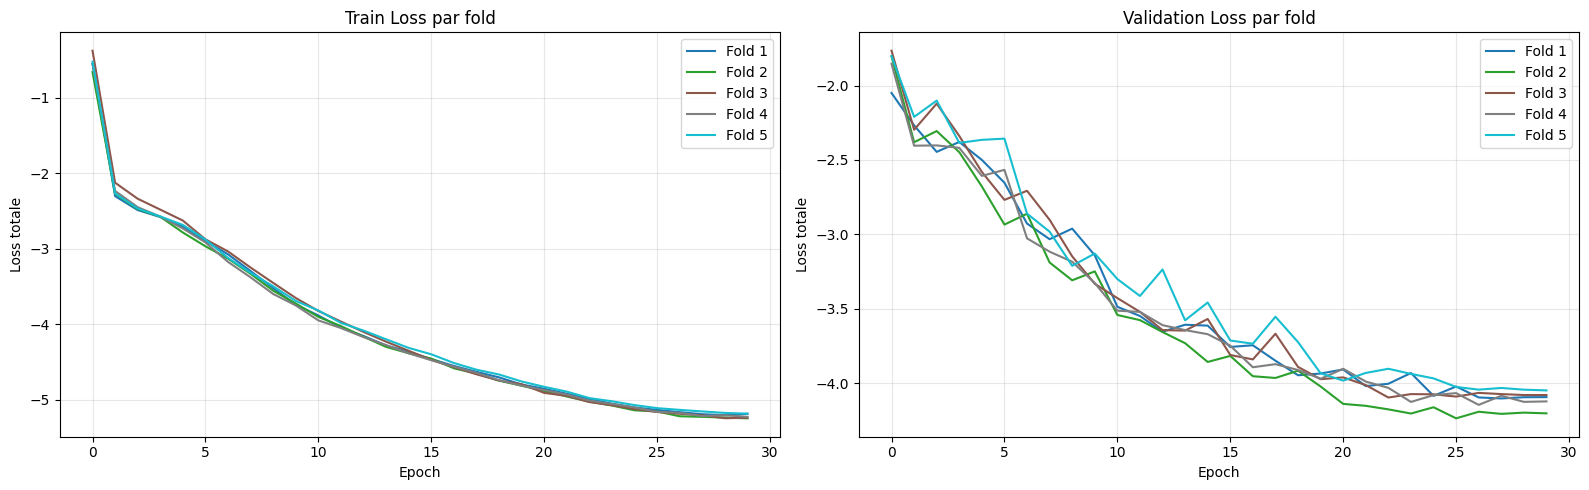

In [13]:
# --- Courbes de loss totale par fold ---
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
colors = plt.cm.tab10(np.linspace(0, 1, N_FOLDS))

for fold in range(N_FOLDS):
    axes[0].plot(all_train_losses[fold], color=colors[fold], linewidth=1.5, label=f'Fold {fold+1}')
    axes[1].plot(all_val_losses[fold], color=colors[fold], linewidth=1.5, label=f'Fold {fold+1}')

axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss totale')
axes[0].set_title('Train Loss par fold'); axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Loss totale')
axes[1].set_title('Validation Loss par fold'); axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

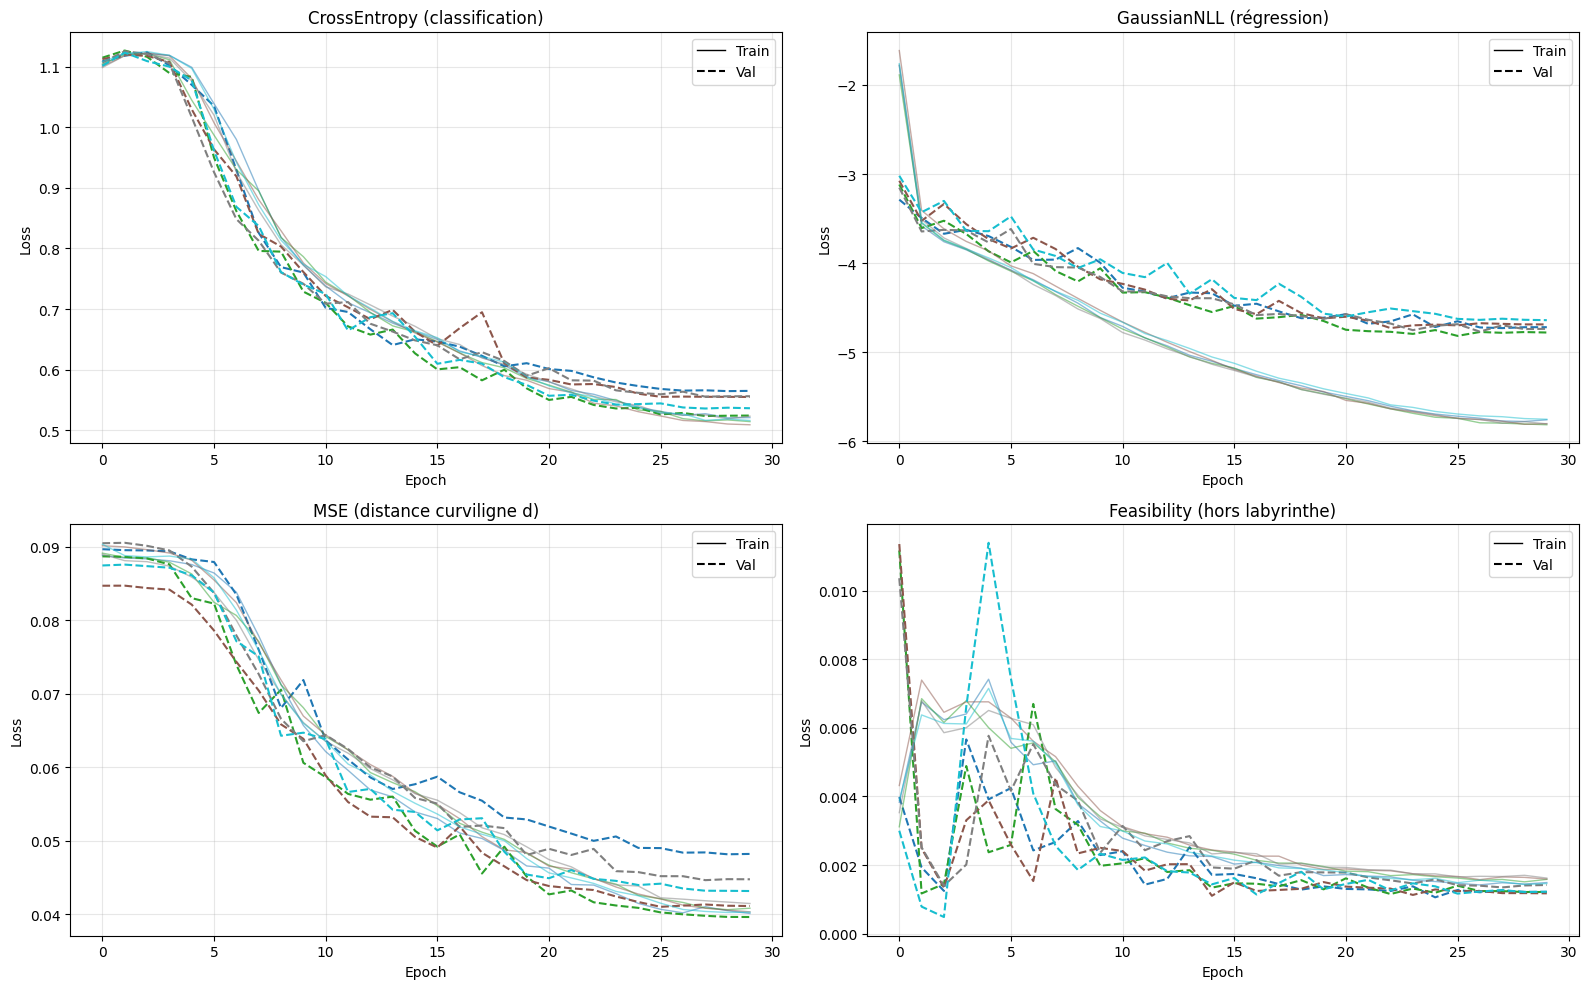

In [14]:
# --- Décomposition des sous-losses (moyenne sur les folds) ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
loss_keys = ['cls', 'pos', 'd', 'feas']
loss_titles = ['CrossEntropy (classification)', 'GaussianNLL (régression)', 'MSE (distance curviligne d)', 'Feasibility (hors labyrinthe)']

for ax_idx, (key, title) in enumerate(zip(loss_keys, loss_titles)):
    ax = axes[ax_idx // 2, ax_idx % 2]
    for fold in range(N_FOLDS):
        train_vals = [d[key] for d in all_train_losses_detail[fold]]
        val_vals = [d[key] for d in all_val_losses_detail[fold]]
        ax.plot(train_vals, color=colors[fold], linewidth=1, alpha=0.5)
        ax.plot(val_vals, color=colors[fold], linewidth=1.5, linestyle='--')
    # Legend
    ax.plot([], [], 'k-', linewidth=1, label='Train')
    ax.plot([], [], 'k--', linewidth=1.5, label='Val')
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
    ax.set_title(title); ax.legend(); ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Évaluation finale sur le test set (ensemble 5 folds)

In [15]:
criterion_ce = nn.CrossEntropyLoss()
criterion_nll = nn.GaussianNLLLoss()
criterion_d = nn.MSELoss()
feas_loss_fn = FeasibilityLoss(SKELETON_SEGMENTS, CORRIDOR_HALF_WIDTH).to(DEVICE)

all_fold_mu, all_fold_sigma, all_fold_probs, all_fold_d = [], [], [], []

for fold in range(N_FOLDS):
    model = SpikeTransformerHierarchical(
        nGroups, nChannelsPerGroup, n_zones=N_ZONES,
        embed_dim=EMBED_DIM, nhead=NHEAD, num_layers=NUM_LAYERS,
        dropout=DROPOUT, spike_dropout=SPIKE_DROPOUT, noise_std=NOISE_STD
    ).to(DEVICE)
    model.load_state_dict(torch.load(f'../outputs/best_transformer_02i_fold{fold+1}.pt', map_location=DEVICE, weights_only=True))
    
    _, fold_acc, (fold_mu, fold_sigma, fold_probs, fold_d, y_test, d_test_targets, zone_test_targets) = eval_epoch(
        model, test_loader, criterion_ce, criterion_nll, criterion_d, feas_loss_fn, DEVICE
    )
    all_fold_mu.append(fold_mu); all_fold_sigma.append(fold_sigma)
    all_fold_probs.append(fold_probs); all_fold_d.append(fold_d)
    fold_eucl = np.sqrt(((y_test - fold_mu) ** 2).sum(axis=1))
    print(f'Fold {fold+1}: Eucl={fold_eucl.mean():.4f}, cls_acc={fold_acc:.1%}')

# Ensemble
all_fold_mu = np.stack(all_fold_mu)
all_fold_sigma = np.stack(all_fold_sigma)
all_fold_probs = np.stack(all_fold_probs)
all_fold_d = np.stack(all_fold_d)

y_pred = all_fold_mu.mean(axis=0)
d_pred_ensemble = all_fold_d.mean(axis=0).squeeze()
probs_ensemble = all_fold_probs.mean(axis=0)
zone_pred = probs_ensemble.argmax(axis=1)

# Sigma ensemble (loi de la variance totale)
mean_var = (all_fold_sigma ** 2).mean(axis=0)
var_mu = all_fold_mu.var(axis=0)
y_sigma = np.sqrt(mean_var + var_mu)

# Métriques
mse_x = mean_squared_error(y_test[:, 0], y_pred[:, 0])
mse_y = mean_squared_error(y_test[:, 1], y_pred[:, 1])
mae_x = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
mae_y = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
r2_x = r2_score(y_test[:, 0], y_pred[:, 0])
r2_y = r2_score(y_test[:, 1], y_pred[:, 1])
eucl_errors = np.sqrt(((y_test - y_pred) ** 2).sum(axis=1))
d_mae = np.abs(d_test_targets - d_pred_ensemble).mean()
d_r2 = r2_score(d_test_targets, d_pred_ensemble)
cls_accuracy = (zone_pred == zone_test_targets).mean()

# Distance au squelette
test_dist_to_skel = np.array([compute_distance_to_skeleton(y_pred[i, 0], y_pred[i, 1]) for i in range(len(y_pred))])
pct_outside = (test_dist_to_skel > CORRIDOR_HALF_WIDTH).mean()

zone_confusion = zone_pred != zone_test_targets
zone_confusion_rate = zone_confusion.mean()

print(f'\n{"="*60}')
print(f'02i Combined — Ensemble ({N_FOLDS} folds)')
print(f'{"="*60}')
print(f'  MSE  : X={mse_x:.5f}, Y={mse_y:.5f}')
print(f'  MAE  : X={mae_x:.4f}, Y={mae_y:.4f}')
print(f'  R²   : X={r2_x:.4f}, Y={r2_y:.4f}')
print(f'  Eucl : mean={eucl_errors.mean():.4f}, median={np.median(eucl_errors):.4f}, p90={np.percentile(eucl_errors, 90):.4f}')
print(f'\n  d curviligne : MAE={d_mae:.4f}, R²={d_r2:.4f}')
print(f'  Classification zone : accuracy={cls_accuracy:.1%}')
print(f'  Hors labyrinthe : {pct_outside:.1%}')
print(f'  Confusion de zone : {zone_confusion_rate:.1%}')

print(f'\n  Erreur par zone :')
for z in range(N_ZONES):
    zmask = zone_test_targets == z
    if zmask.any():
        z_acc = (zone_pred[zmask] == z).mean()
        print(f'    {ZONE_NAMES[z]:8s} : Eucl={eucl_errors[zmask].mean():.4f} | cls_acc={z_acc:.1%} ({zmask.sum()} pts)')

print(f'\n  Sigma moyen : X={y_sigma[:, 0].mean():.4f}, Y={y_sigma[:, 1].mean():.4f}')

Fold 1: Eucl=0.2286, cls_acc=73.8%
Fold 2: Eucl=0.2384, cls_acc=73.4%
Fold 3: Eucl=0.2406, cls_acc=71.6%
Fold 4: Eucl=0.2376, cls_acc=73.8%
Fold 5: Eucl=0.2401, cls_acc=74.5%

02i Combined — Ensemble (5 folds)
  MSE  : X=0.03835, Y=0.04067
  MAE  : X=0.1359, Y=0.1455
  R²   : X=0.5219, Y=0.6152
  Eucl : mean=0.2246, median=0.1753, p90=0.4789

  d curviligne : MAE=0.1301, R²=0.4932
  Classification zone : accuracy=75.4%
  Hors labyrinthe : 16.0%
  Confusion de zone : 24.6%

  Erreur par zone :
    Gauche   : Eucl=0.2194 | cls_acc=82.8% (851 pts)
    Haut     : Eucl=0.1914 | cls_acc=75.7% (947 pts)
    Droite   : Eucl=0.2965 | cls_acc=62.2% (500 pts)

  Sigma moyen : X=0.1757, Y=0.1560


## 12. Visualisations standard

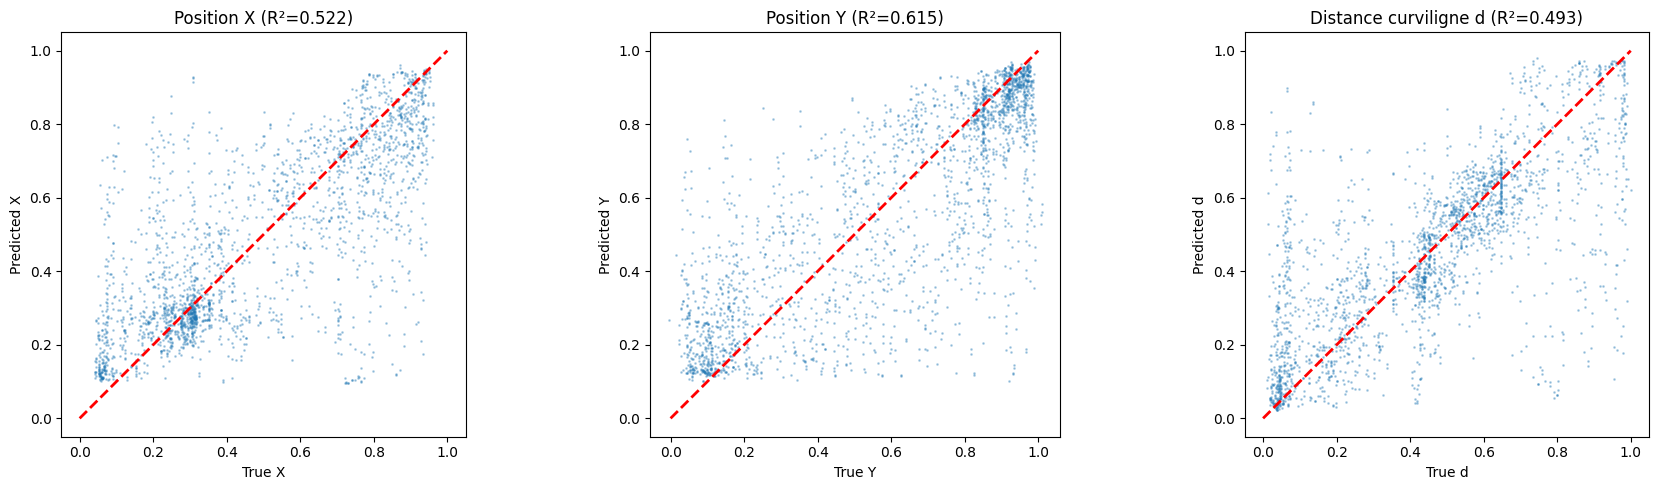

In [16]:
# --- Scatter pred vs true (X, Y, d) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(y_test[:, 0], y_pred[:, 0], s=1, alpha=0.3)
axes[0].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[0].set_xlabel('True X'); axes[0].set_ylabel('Predicted X')
axes[0].set_title(f'Position X (R²={r2_x:.3f})'); axes[0].set_aspect('equal')

axes[1].scatter(y_test[:, 1], y_pred[:, 1], s=1, alpha=0.3)
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[1].set_xlabel('True Y'); axes[1].set_ylabel('Predicted Y')
axes[1].set_title(f'Position Y (R²={r2_y:.3f})'); axes[1].set_aspect('equal')

axes[2].scatter(d_test_targets, d_pred_ensemble, s=1, alpha=0.3)
axes[2].plot([0, 1], [0, 1], 'r--', linewidth=2)
axes[2].set_xlabel('True d'); axes[2].set_ylabel('Predicted d')
axes[2].set_title(f'Distance curviligne d (R²={d_r2:.3f})'); axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

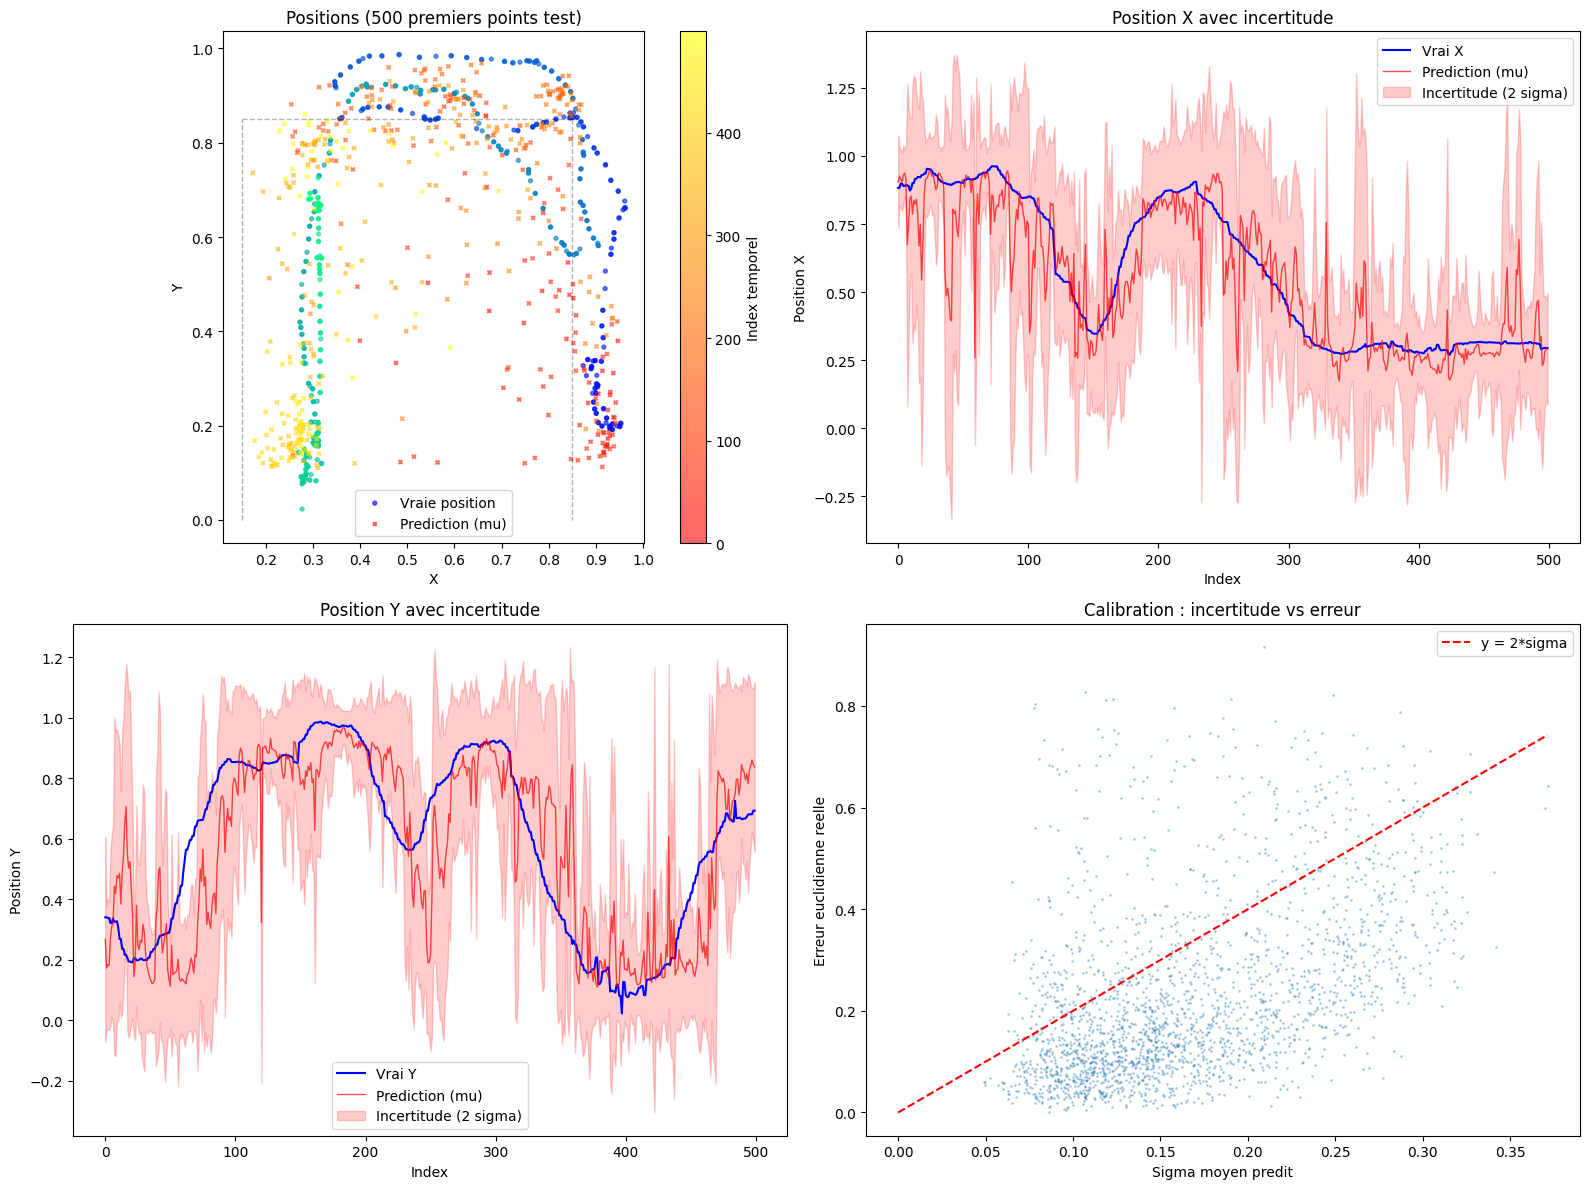

Calibration de l'incertitude :
  Erreur < 1*sigma : 43.8% (attendu ~39% pour gaussienne 2D)
  Erreur < 2*sigma : 81.4% (attendu ~86%)
  Erreur < 3*sigma : 93.5% (attendu ~99%)


In [17]:
# --- Points prédits vs vrais avec incertitude (500 premiers points) ---
segment = slice(0, 500)
seg_idx = np.arange(500)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Points 2D colorés par ordre chronologique
colors_pts = np.arange(500)
axes[0, 0].scatter(y_test[segment, 0], y_test[segment, 1], c=colors_pts, cmap='winter', s=8, alpha=0.6, label='Vraie position')
sc = axes[0, 0].scatter(y_pred[segment, 0], y_pred[segment, 1], c=colors_pts, cmap='autumn', s=8, alpha=0.6, marker='x', label='Prediction (mu)')
for x1, y1, x2, y2 in SKELETON_SEGMENTS:
    axes[0, 0].plot([x1, x2], [y1, y2], 'k--', linewidth=1, alpha=0.3)
axes[0, 0].set_xlabel('X'); axes[0, 0].set_ylabel('Y')
axes[0, 0].set_title('Positions (500 premiers points test)')
axes[0, 0].legend(); axes[0, 0].set_aspect('equal')
cbar = plt.colorbar(sc, ax=axes[0, 0])
cbar.set_label('Index temporel')

# 2. Position X avec bande d'incertitude
axes[0, 1].plot(seg_idx, y_test[segment, 0], 'b-', label='Vrai X', linewidth=1.5)
axes[0, 1].plot(seg_idx, y_pred[segment, 0], 'r-', alpha=0.7, label='Prediction (mu)', linewidth=1)
axes[0, 1].fill_between(seg_idx, 
                         y_pred[segment, 0] - 2 * y_sigma[segment, 0],
                         y_pred[segment, 0] + 2 * y_sigma[segment, 0],
                         alpha=0.2, color='red', label='Incertitude (2 sigma)')
axes[0, 1].set_xlabel('Index'); axes[0, 1].set_ylabel('Position X')
axes[0, 1].set_title('Position X avec incertitude'); axes[0, 1].legend()

# 3. Position Y avec bande d'incertitude
axes[1, 0].plot(seg_idx, y_test[segment, 1], 'b-', label='Vrai Y', linewidth=1.5)
axes[1, 0].plot(seg_idx, y_pred[segment, 1], 'r-', alpha=0.7, label='Prediction (mu)', linewidth=1)
axes[1, 0].fill_between(seg_idx,
                         y_pred[segment, 1] - 2 * y_sigma[segment, 1],
                         y_pred[segment, 1] + 2 * y_sigma[segment, 1],
                         alpha=0.2, color='red', label='Incertitude (2 sigma)')
axes[1, 0].set_xlabel('Index'); axes[1, 0].set_ylabel('Position Y')
axes[1, 0].set_title('Position Y avec incertitude'); axes[1, 0].legend()

# 4. Calibration incertitude vs erreur
sigma_mean = (y_sigma[:, 0] + y_sigma[:, 1]) / 2
axes[1, 1].scatter(sigma_mean, eucl_errors, s=1, alpha=0.3)
axes[1, 1].set_xlabel('Sigma moyen predit'); axes[1, 1].set_ylabel('Erreur euclidienne reelle')
axes[1, 1].set_title('Calibration : incertitude vs erreur')
sigma_range = np.linspace(0, sigma_mean.max(), 100)
axes[1, 1].plot(sigma_range, 2 * sigma_range, 'r--', label='y = 2*sigma', linewidth=1.5)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Calibration
in_1sigma = np.mean(eucl_errors < sigma_mean)
in_2sigma = np.mean(eucl_errors < 2 * sigma_mean)
in_3sigma = np.mean(eucl_errors < 3 * sigma_mean)
print(f'Calibration de l\'incertitude :')
print(f'  Erreur < 1*sigma : {in_1sigma:.1%} (attendu ~39% pour gaussienne 2D)')
print(f'  Erreur < 2*sigma : {in_2sigma:.1%} (attendu ~86%)')
print(f'  Erreur < 3*sigma : {in_3sigma:.1%} (attendu ~99%)')

## 13. Visualisations spécifiques : Feasibility

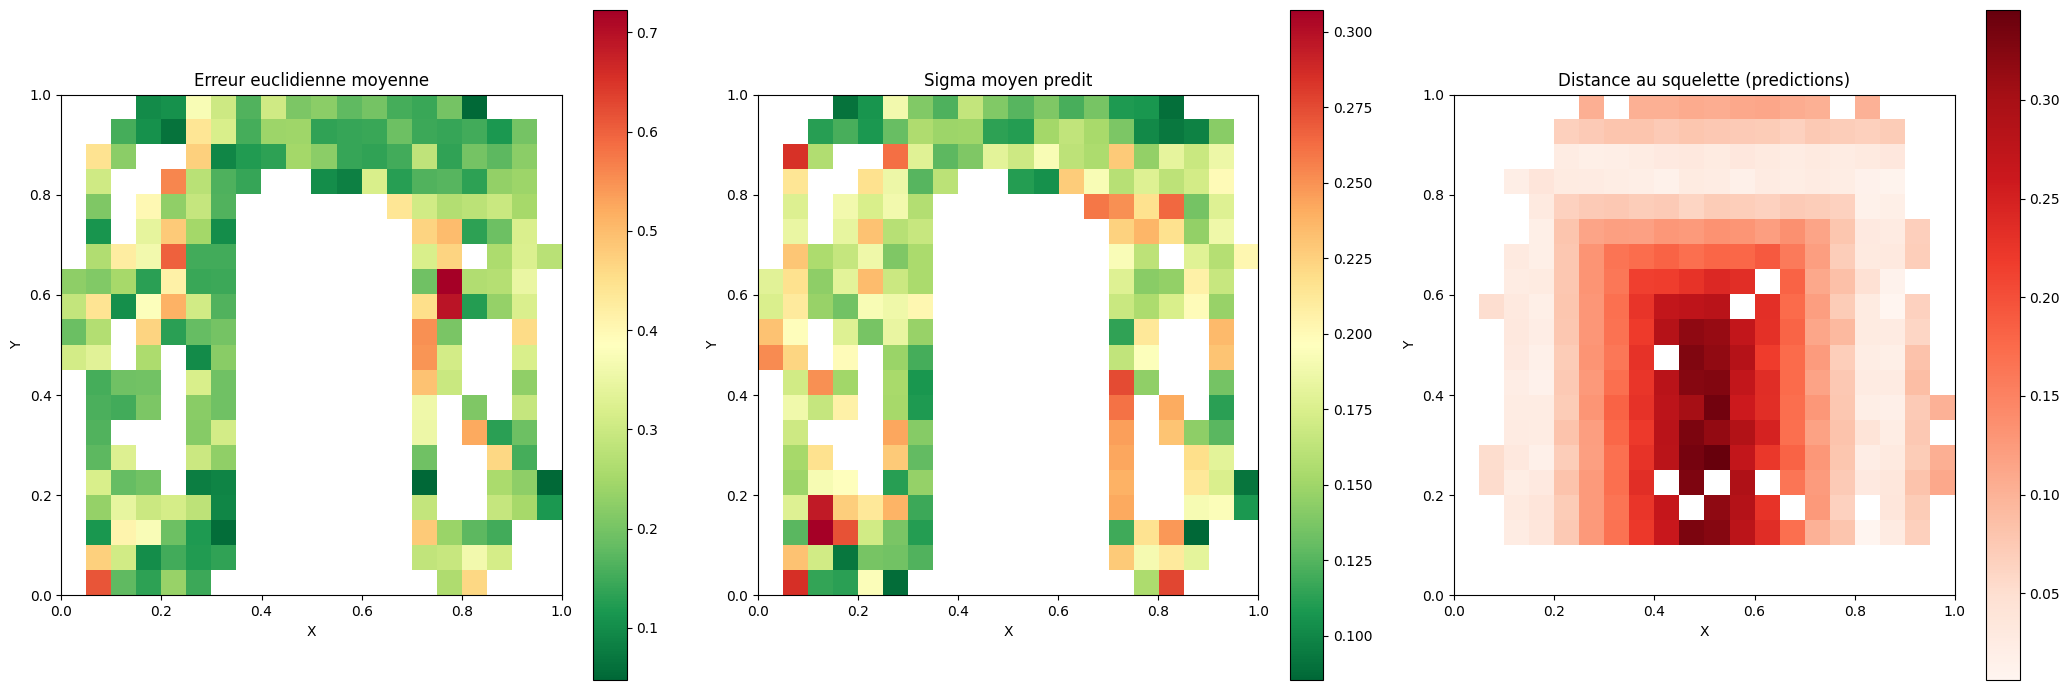

Prédictions hors labyrinthe : 16.0%
Distance moyenne au squelette : 0.0902


In [18]:
# --- Heatmaps : erreur + sigma + distance au squelette ---
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

nbins = 20
x_edges = np.linspace(0, 1, nbins + 1)
y_edges = np.linspace(0, 1, nbins + 1)

for ax_idx, (title, values, cmap, pos_for_binning) in enumerate([
    ('Erreur euclidienne moyenne', eucl_errors, 'RdYlGn_r', y_test),
    ('Sigma moyen predit', (y_sigma[:, 0] + y_sigma[:, 1]) / 2, 'RdYlGn_r', y_test),
    ('Distance au squelette (predictions)', test_dist_to_skel, 'Reds', y_pred)
]):
    val_map = np.full((nbins, nbins), np.nan)
    count_map = np.zeros((nbins, nbins))
    for i in range(len(pos_for_binning)):
        xi = np.clip(np.searchsorted(x_edges, pos_for_binning[i, 0]) - 1, 0, nbins - 1)
        yi = np.clip(np.searchsorted(y_edges, pos_for_binning[i, 1]) - 1, 0, nbins - 1)
        if np.isnan(val_map[yi, xi]):
            val_map[yi, xi] = 0
        val_map[yi, xi] += values[i]
        count_map[yi, xi] += 1
    mean_map = np.where(count_map > 0, val_map / count_map, np.nan)
    im = axes[ax_idx].imshow(mean_map, origin='lower', aspect='equal', cmap=cmap, extent=[0, 1, 0, 1])
    axes[ax_idx].set_xlabel('X'); axes[ax_idx].set_ylabel('Y')
    axes[ax_idx].set_title(title); plt.colorbar(im, ax=axes[ax_idx])

plt.tight_layout()
plt.show()

print(f'Prédictions hors labyrinthe : {pct_outside:.1%}')
print(f'Distance moyenne au squelette : {test_dist_to_skel.mean():.4f}')

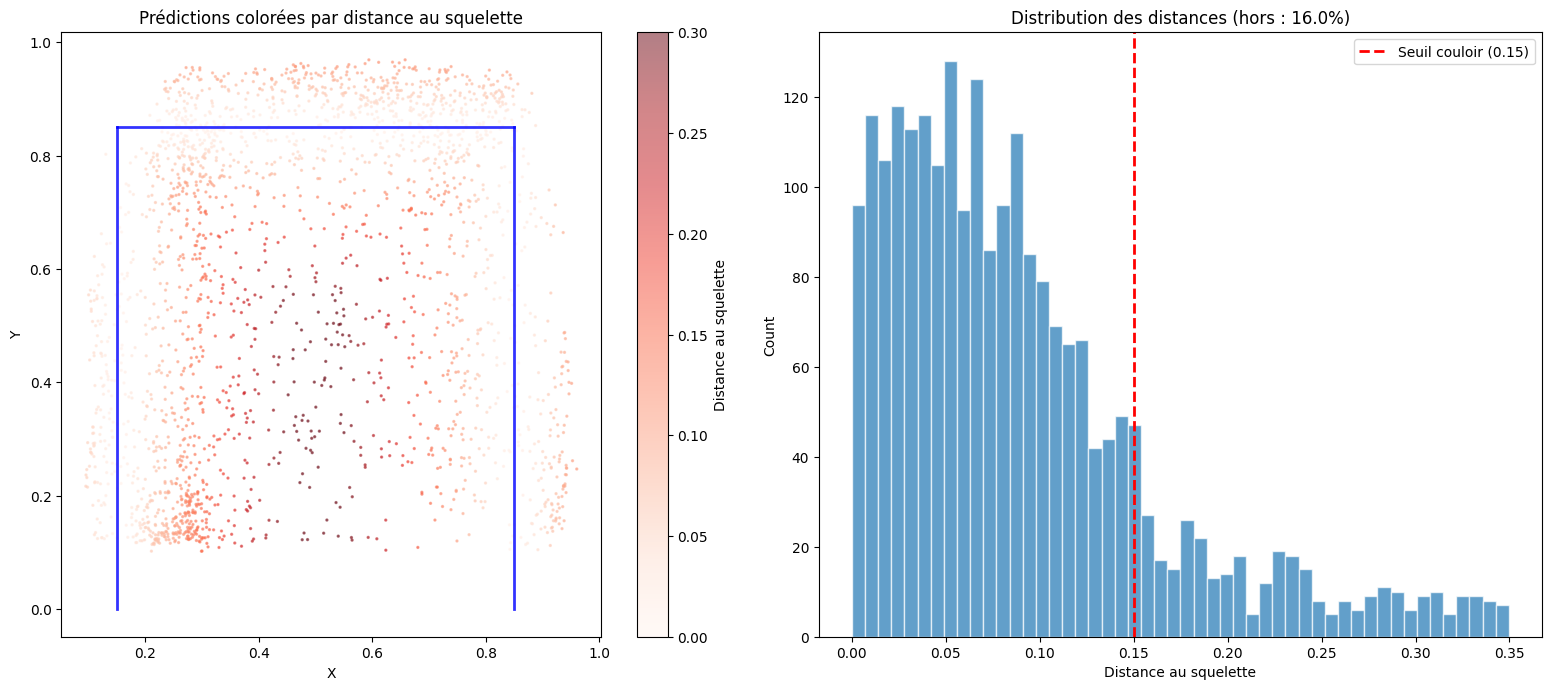

In [19]:
# --- Scatter des prédictions avec couleur = distance au squelette ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 1. Prédictions colorées par distance au squelette
sc = axes[0].scatter(y_pred[:, 0], y_pred[:, 1], c=test_dist_to_skel, cmap='Reds', s=2, alpha=0.5, vmin=0, vmax=0.3)
for x1, y1, x2, y2 in SKELETON_SEGMENTS:
    axes[0].plot([x1, x2], [y1, y2], 'b-', linewidth=2, alpha=0.8)
axes[0].set_xlabel('X'); axes[0].set_ylabel('Y')
axes[0].set_title('Prédictions colorées par distance au squelette')
axes[0].set_aspect('equal')
plt.colorbar(sc, ax=axes[0], label='Distance au squelette')

# 2. Histogramme de la distance au squelette
axes[1].hist(test_dist_to_skel, bins=50, alpha=0.7, edgecolor='white')
axes[1].axvline(CORRIDOR_HALF_WIDTH, color='red', linestyle='--', linewidth=2, label=f'Seuil couloir ({CORRIDOR_HALF_WIDTH})')
axes[1].set_xlabel('Distance au squelette')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Distribution des distances (hors : {pct_outside:.1%})')
axes[1].legend()

plt.tight_layout()
plt.show()

## 14. Visualisations spécifiques : Clustering hiérarchique 3 zones

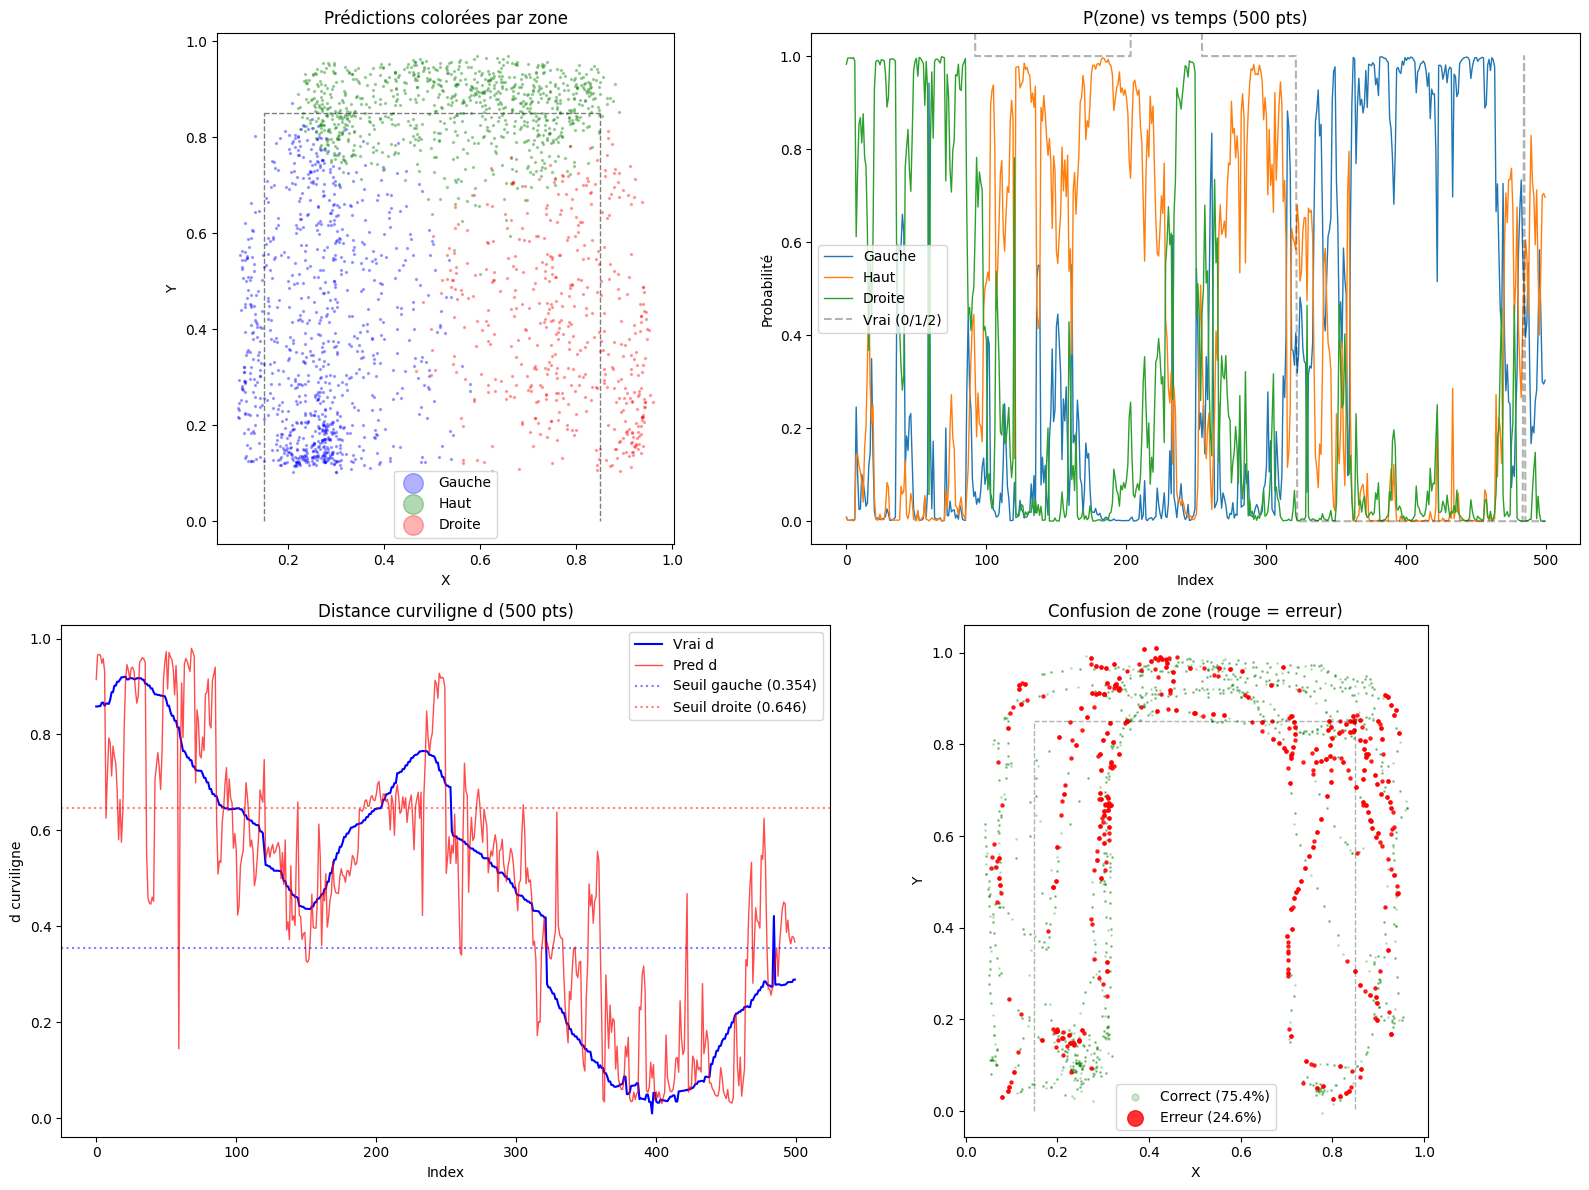

In [20]:
# --- Trajectoire + zone probabilities ---
segment = slice(0, 500)
seg_idx = np.arange(500)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Trajectoire 2D colorée par zone prédite
zone_colors_map = ['blue', 'green', 'red']
for z in range(N_ZONES):
    zmask = zone_pred == z
    axes[0, 0].scatter(y_pred[zmask, 0], y_pred[zmask, 1], c=zone_colors_map[z], s=2, alpha=0.3, label=f'{ZONE_NAMES[z]}')
for x1, y1, x2, y2 in SKELETON_SEGMENTS:
    axes[0, 0].plot([x1, x2], [y1, y2], 'k--', linewidth=1, alpha=0.5)
axes[0, 0].set_xlabel('X'); axes[0, 0].set_ylabel('Y')
axes[0, 0].set_title('Prédictions colorées par zone')
axes[0, 0].legend(markerscale=10); axes[0, 0].set_aspect('equal')

# 2. Probabilités de zone dans le temps (500 pts)
for z in range(N_ZONES):
    axes[0, 1].plot(seg_idx, probs_ensemble[segment, z], label=ZONE_NAMES[z], linewidth=1)
axes[0, 1].plot(seg_idx, zone_test_targets[segment], 'k--', alpha=0.3, label='Vrai (0/1/2)')
axes[0, 1].set_xlabel('Index'); axes[0, 1].set_ylabel('Probabilité')
axes[0, 1].set_title('P(zone) vs temps (500 pts)'); axes[0, 1].legend()
axes[0, 1].set_ylim(-0.05, 1.05)

# 3. Distance curviligne prédite vs vraie
axes[1, 0].plot(seg_idx, d_test_targets[segment], 'b-', label='Vrai d', linewidth=1.5)
axes[1, 0].plot(seg_idx, d_pred_ensemble[segment], 'r-', alpha=0.7, label='Pred d', linewidth=1)
axes[1, 0].axhline(y=D_LEFT_END, color='blue', linestyle=':', alpha=0.5, label=f'Seuil gauche ({D_LEFT_END:.3f})')
axes[1, 0].axhline(y=D_RIGHT_START, color='red', linestyle=':', alpha=0.5, label=f'Seuil droite ({D_RIGHT_START:.3f})')
axes[1, 0].set_xlabel('Index'); axes[1, 0].set_ylabel('d curviligne')
axes[1, 0].set_title('Distance curviligne d (500 pts)'); axes[1, 0].legend()

# 4. Carte confusion (correct/erreur de zone)
correct = ~zone_confusion
axes[1, 1].scatter(y_test[correct, 0], y_test[correct, 1], c='green', s=1, alpha=0.2, label=f'Correct ({correct.mean():.1%})')
if zone_confusion.any():
    axes[1, 1].scatter(y_test[zone_confusion, 0], y_test[zone_confusion, 1], c='red', s=5, alpha=0.8, label=f'Erreur ({zone_confusion_rate:.1%})')
for x1, y1, x2, y2 in SKELETON_SEGMENTS:
    axes[1, 1].plot([x1, x2], [y1, y2], 'k--', linewidth=1, alpha=0.3)
axes[1, 1].set_xlabel('X'); axes[1, 1].set_ylabel('Y')
axes[1, 1].set_title('Confusion de zone (rouge = erreur)'); axes[1, 1].legend(markerscale=5)
axes[1, 1].set_aspect('equal')

plt.tight_layout()
plt.show()

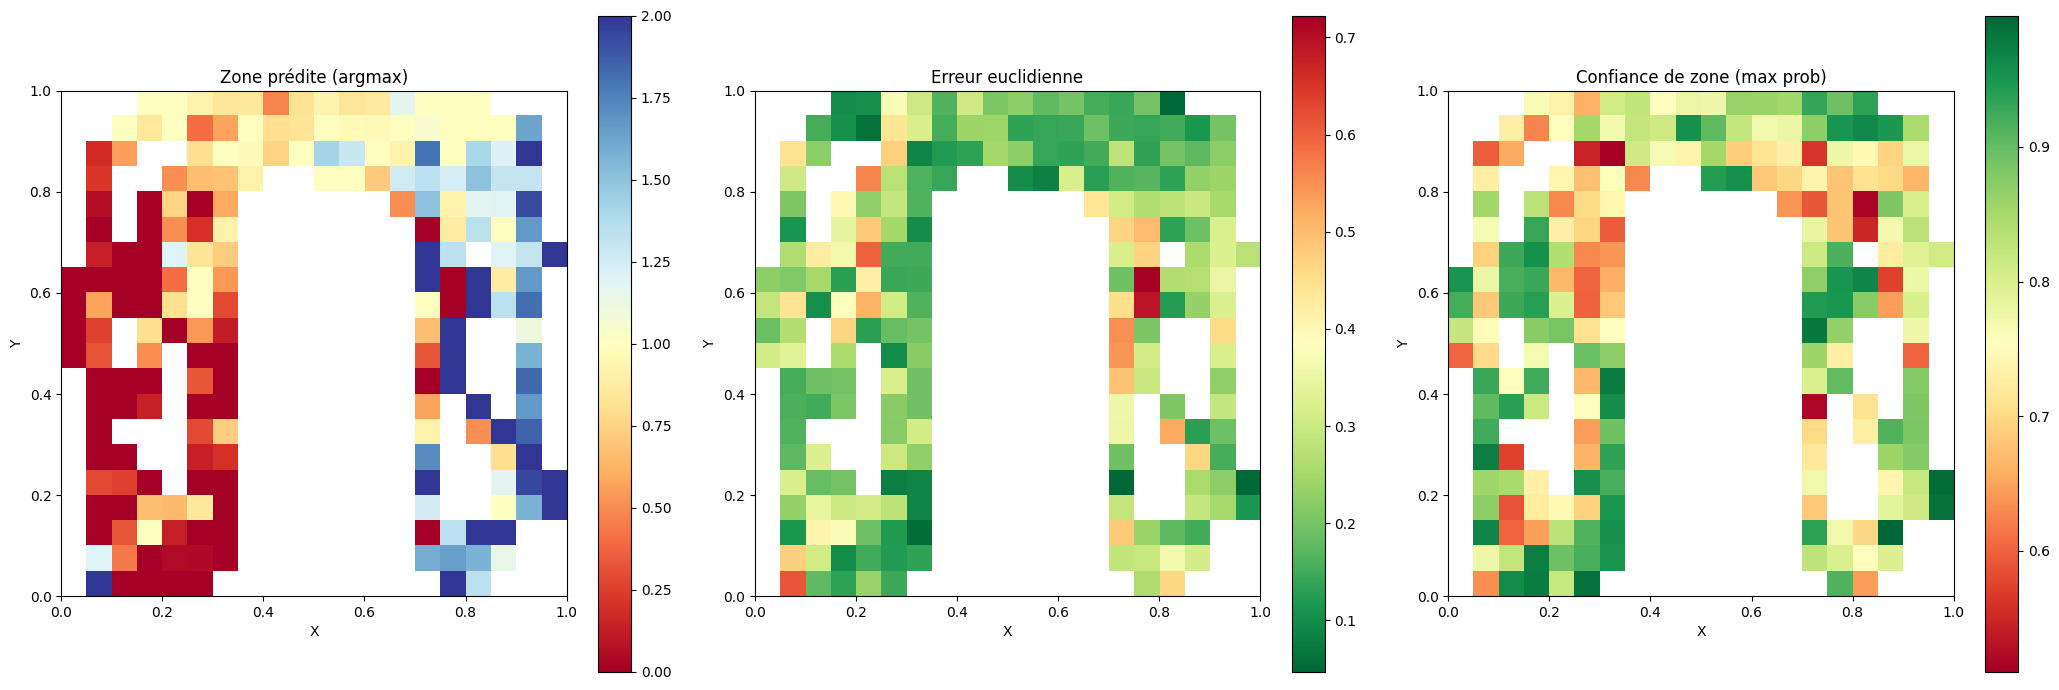

In [21]:
# --- Heatmap zone prédite + erreur par zone ---
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

nbins = 20
x_edges = np.linspace(0, 1, nbins + 1)
y_edges = np.linspace(0, 1, nbins + 1)

for ax_idx, (title, values, cmap) in enumerate([
    ('Zone prédite (argmax)', zone_pred.astype(float), 'RdYlBu'),
    ('Erreur euclidienne', eucl_errors, 'RdYlGn_r'),
    ('Confiance de zone (max prob)', probs_ensemble.max(axis=1), 'RdYlGn')
]):
    val_map = np.full((nbins, nbins), np.nan)
    count_map = np.zeros((nbins, nbins))
    for i in range(len(y_test)):
        xi = np.clip(np.searchsorted(x_edges, y_test[i, 0]) - 1, 0, nbins - 1)
        yi = np.clip(np.searchsorted(y_edges, y_test[i, 1]) - 1, 0, nbins - 1)
        if np.isnan(val_map[yi, xi]):
            val_map[yi, xi] = 0
        val_map[yi, xi] += values[i]
        count_map[yi, xi] += 1
    mean_map = np.where(count_map > 0, val_map / count_map, np.nan)
    im = axes[ax_idx].imshow(mean_map, origin='lower', aspect='equal', cmap=cmap, extent=[0, 1, 0, 1])
    axes[ax_idx].set_title(title)
    axes[ax_idx].set_xlabel('X'); axes[ax_idx].set_ylabel('Y')
    plt.colorbar(im, ax=axes[ax_idx])

plt.tight_layout()
plt.show()

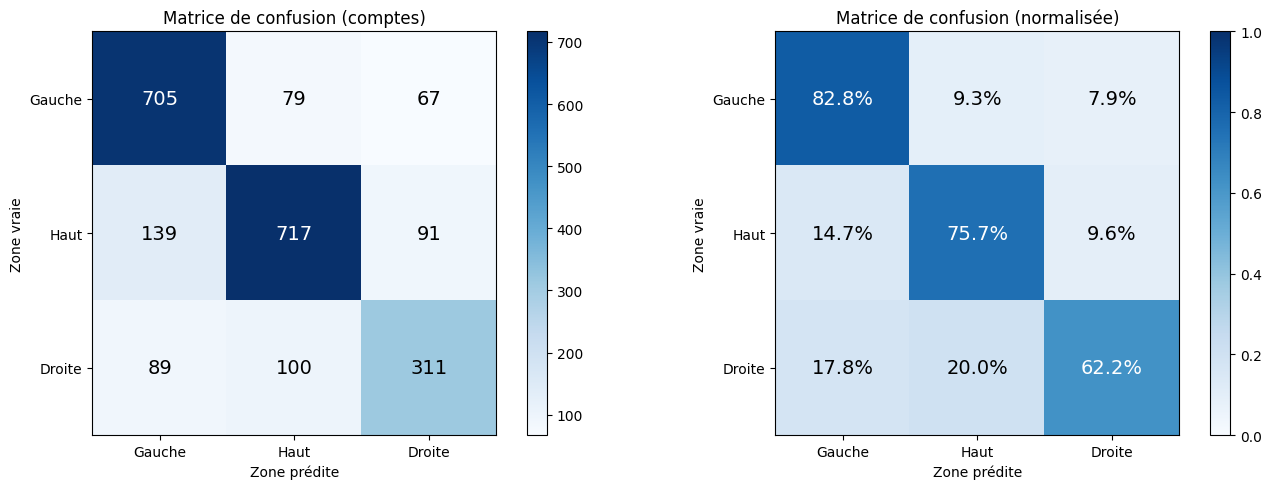

Accuracy globale : 75.4%
  Gauche   : recall=82.8%
  Haut     : recall=75.7%
  Droite   : recall=62.2%


In [22]:
# --- Confusion matrix 3 classes ---
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(zone_test_targets, zone_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matrice de confusion brute
im0 = axes[0].imshow(cm, cmap='Blues')
for i in range(N_ZONES):
    for j in range(N_ZONES):
        axes[0].text(j, i, f'{cm[i, j]}', ha='center', va='center', fontsize=14,
                     color='white' if cm[i, j] > cm.max() / 2 else 'black')
axes[0].set_xticks(range(N_ZONES)); axes[0].set_xticklabels(ZONE_NAMES)
axes[0].set_yticks(range(N_ZONES)); axes[0].set_yticklabels(ZONE_NAMES)
axes[0].set_xlabel('Zone prédite'); axes[0].set_ylabel('Zone vraie')
axes[0].set_title('Matrice de confusion (comptes)')
plt.colorbar(im0, ax=axes[0])

# Matrice de confusion normalisée
im1 = axes[1].imshow(cm_norm, cmap='Blues', vmin=0, vmax=1)
for i in range(N_ZONES):
    for j in range(N_ZONES):
        axes[1].text(j, i, f'{cm_norm[i, j]:.1%}', ha='center', va='center', fontsize=14,
                     color='white' if cm_norm[i, j] > 0.5 else 'black')
axes[1].set_xticks(range(N_ZONES)); axes[1].set_xticklabels(ZONE_NAMES)
axes[1].set_yticks(range(N_ZONES)); axes[1].set_yticklabels(ZONE_NAMES)
axes[1].set_xlabel('Zone prédite'); axes[1].set_ylabel('Zone vraie')
axes[1].set_title('Matrice de confusion (normalisée)')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

print(f'Accuracy globale : {cls_accuracy:.1%}')
for z in range(N_ZONES):
    print(f'  {ZONE_NAMES[z]:8s} : recall={cm_norm[z, z]:.1%}')

## 15. Visualisations spécifiques : Dropout et bruit gaussien

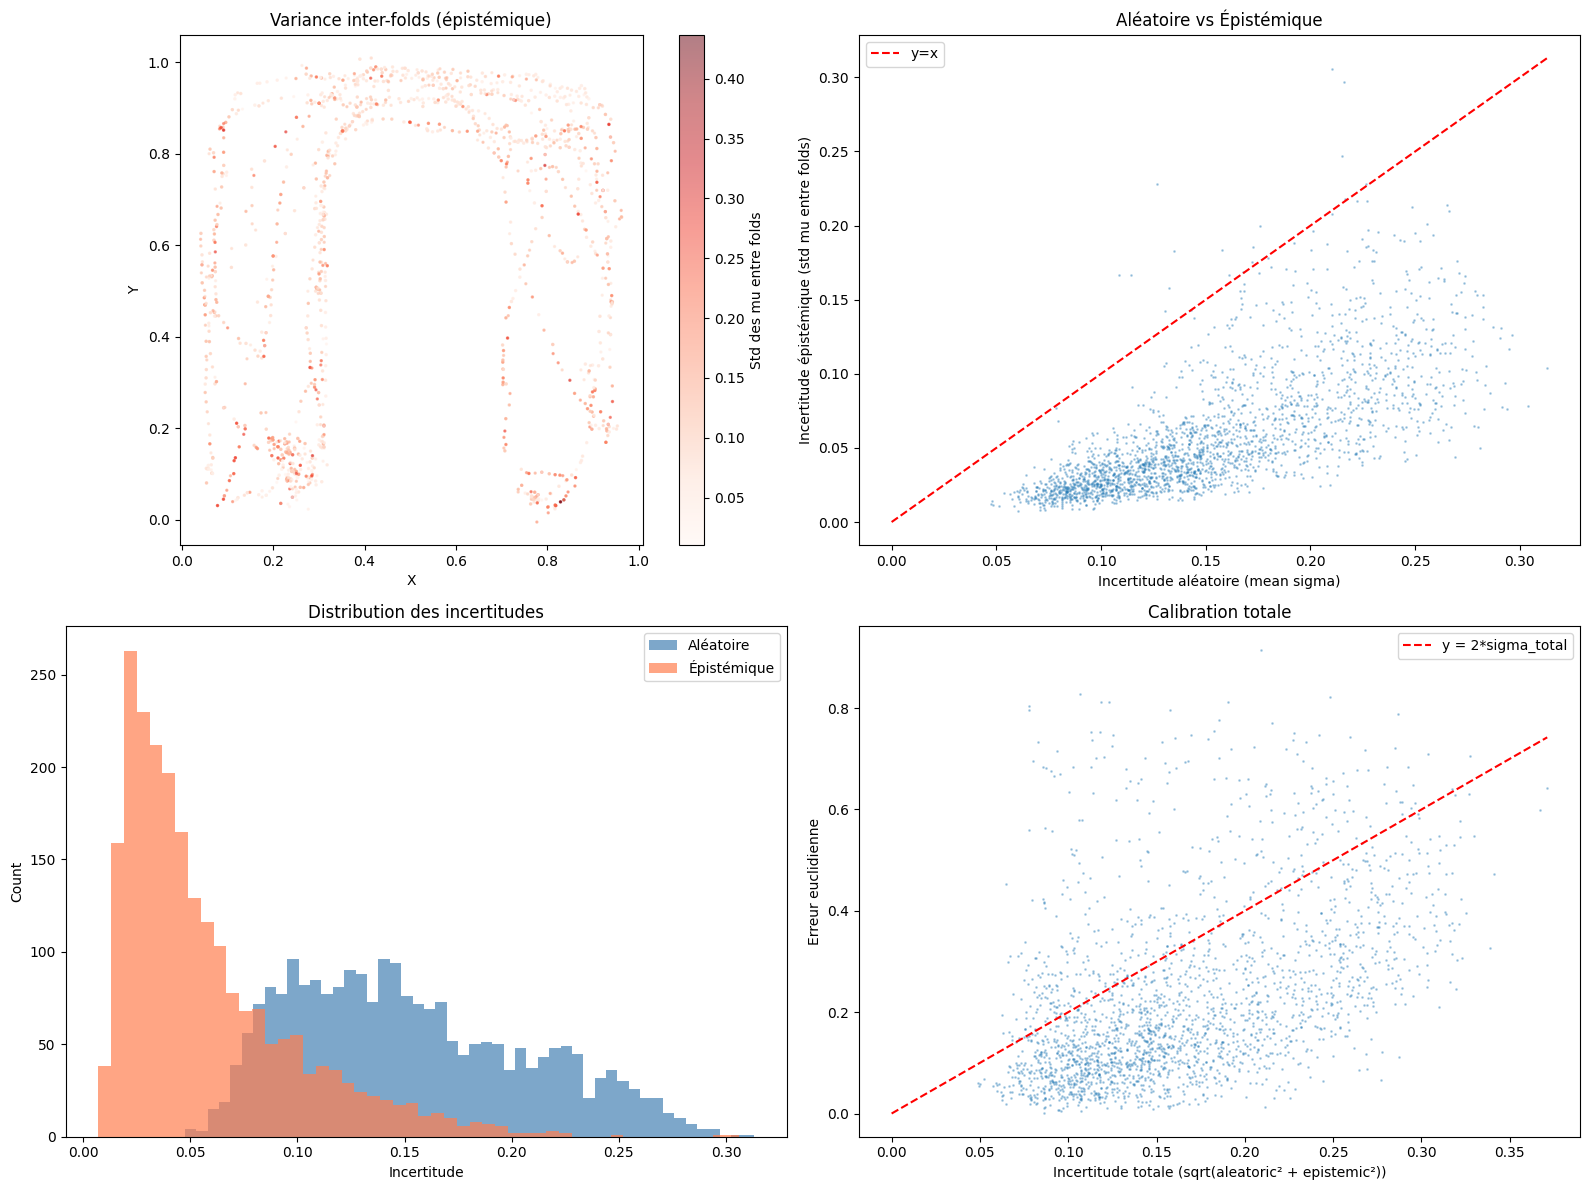

Corrélation (Spearman) incertitude vs erreur :
  Aléatoire  : 0.492
  Épistémique: 0.431
  Totale     : 0.502


In [23]:
# --- Analyse de la variance inter-folds (effet du dropout/noise) ---
# La variance entre les 5 folds reflète l'incertitude épistémique,
# amplifiée par le dropout et le bruit gaussien pendant l'entraînement.

fold_std_mu = all_fold_mu.std(axis=0)  # (n_test, 2)
fold_std_x = fold_std_mu[:, 0]
fold_std_y = fold_std_mu[:, 1]
fold_std_eucl = np.sqrt(fold_std_x**2 + fold_std_y**2)

# Incertitude aleatoric (mean sigma) vs epistemic (fold variance)
aleatoric = (all_fold_sigma ** 2).mean(axis=0)  # E[sigma²]
aleatoric_mean = np.sqrt(aleatoric).mean(axis=1)
epistemic = np.sqrt(var_mu).mean(axis=1)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Variance inter-folds par position
sc = axes[0, 0].scatter(y_test[:, 0], y_test[:, 1], c=fold_std_eucl, cmap='Reds', s=2, alpha=0.5)
axes[0, 0].set_xlabel('X'); axes[0, 0].set_ylabel('Y')
axes[0, 0].set_title('Variance inter-folds (épistémique)')
axes[0, 0].set_aspect('equal')
plt.colorbar(sc, ax=axes[0, 0], label='Std des mu entre folds')

# 2. Aleatoric vs Epistemic
axes[0, 1].scatter(aleatoric_mean, epistemic, s=1, alpha=0.3)
max_val = max(aleatoric_mean.max(), epistemic.max())
axes[0, 1].plot([0, max_val], [0, max_val], 'r--', label='y=x')
axes[0, 1].set_xlabel('Incertitude aléatoire (mean sigma)')
axes[0, 1].set_ylabel('Incertitude épistémique (std mu entre folds)')
axes[0, 1].set_title('Aléatoire vs Épistémique')
axes[0, 1].legend()

# 3. Distribution des deux types d'incertitude
axes[1, 0].hist(aleatoric_mean, bins=50, alpha=0.7, label='Aléatoire', color='steelblue')
axes[1, 0].hist(epistemic, bins=50, alpha=0.7, label='Épistémique', color='coral')
axes[1, 0].set_xlabel('Incertitude'); axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Distribution des incertitudes'); axes[1, 0].legend()

# 4. Erreur vs incertitude totale (aleatoric + epistemic)
total_uncertainty = np.sqrt(aleatoric_mean**2 + epistemic**2)
axes[1, 1].scatter(total_uncertainty, eucl_errors, s=1, alpha=0.3)
u_range = np.linspace(0, total_uncertainty.max(), 100)
axes[1, 1].plot(u_range, 2 * u_range, 'r--', label='y = 2*sigma_total')
axes[1, 1].set_xlabel('Incertitude totale (sqrt(aleatoric² + epistemic²))')
axes[1, 1].set_ylabel('Erreur euclidienne')
axes[1, 1].set_title('Calibration totale'); axes[1, 1].legend()

plt.tight_layout()
plt.show()

corr_alea, _ = spearmanr(aleatoric_mean, eucl_errors)
corr_epis, _ = spearmanr(epistemic, eucl_errors)
corr_total, _ = spearmanr(total_uncertainty, eucl_errors)
print(f'Corrélation (Spearman) incertitude vs erreur :')
print(f'  Aléatoire  : {corr_alea:.3f}')
print(f'  Épistémique: {corr_epis:.3f}')
print(f'  Totale     : {corr_total:.3f}')

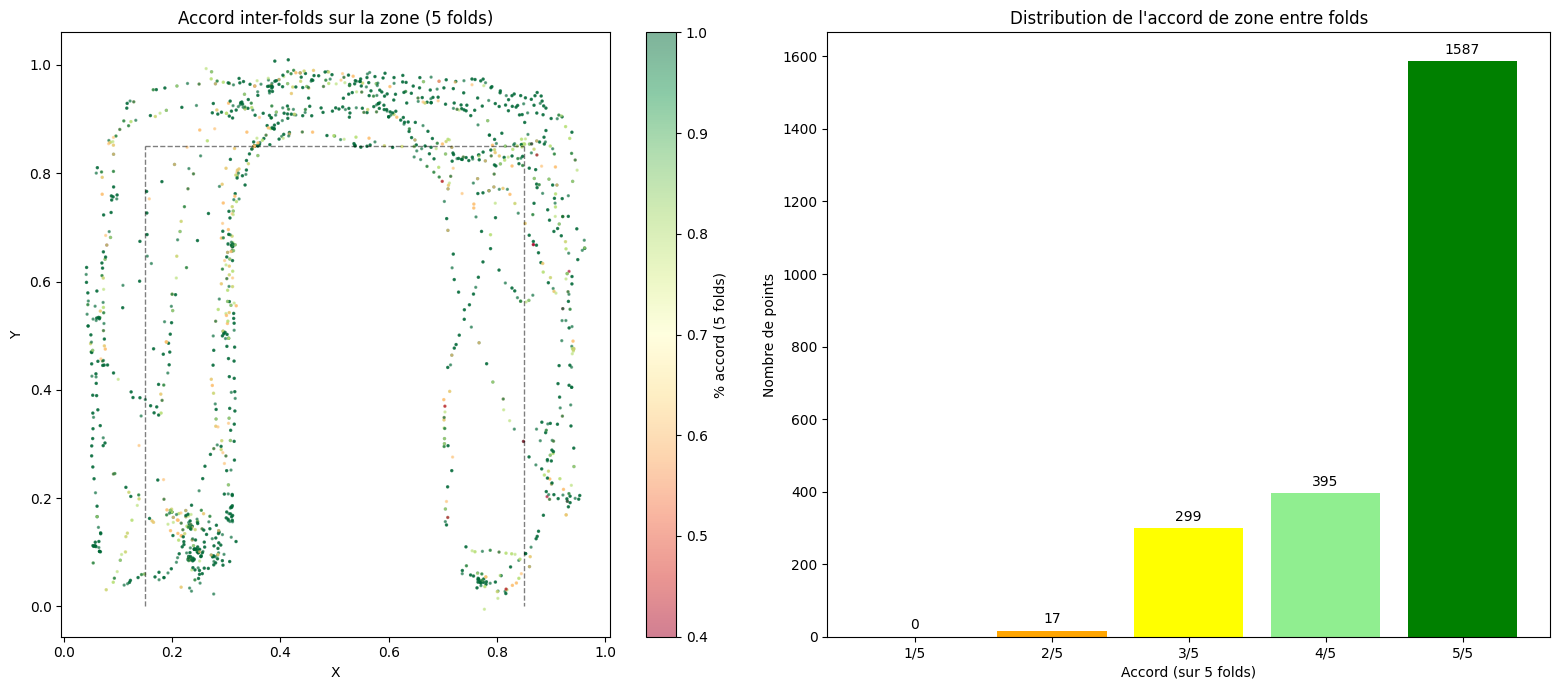

Accord parfait (5/5) : 69.1%
Accord majoritaire (>=3/5) : 99.3%


In [24]:
# --- Accord entre les 5 folds ---
# Pour chaque point, on regarde si les 5 folds prédisent la même zone
fold_zone_preds = np.stack([fp.argmax(axis=1) for fp in all_fold_probs])  # (5, n_test)
zone_agreement = np.zeros(len(y_test))
for i in range(len(y_test)):
    most_common = np.bincount(fold_zone_preds[:, i], minlength=3).max()
    zone_agreement[i] = most_common / N_FOLDS

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 1. Accord de zone spatial
sc = axes[0].scatter(y_test[:, 0], y_test[:, 1], c=zone_agreement, cmap='RdYlGn', s=2, alpha=0.5, vmin=0.4, vmax=1.0)
for x1, y1, x2, y2 in SKELETON_SEGMENTS:
    axes[0].plot([x1, x2], [y1, y2], 'k--', linewidth=1, alpha=0.5)
axes[0].set_xlabel('X'); axes[0].set_ylabel('Y')
axes[0].set_title('Accord inter-folds sur la zone (5 folds)')
axes[0].set_aspect('equal')
plt.colorbar(sc, ax=axes[0], label='% accord (5 folds)')

# 2. Histogramme d'accord
unique_vals = [0.2, 0.4, 0.6, 0.8, 1.0]
counts = [(zone_agreement == v).sum() for v in unique_vals]
labels = ['1/5', '2/5', '3/5', '4/5', '5/5']
bars = axes[1].bar(labels, counts, color=['red', 'orange', 'yellow', 'lightgreen', 'green'])
for bar, c in zip(bars, counts):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, f'{c}', ha='center')
axes[1].set_xlabel('Accord (sur 5 folds)'); axes[1].set_ylabel('Nombre de points')
axes[1].set_title('Distribution de l\'accord de zone entre folds')

plt.tight_layout()
plt.show()

print(f'Accord parfait (5/5) : {(zone_agreement == 1.0).mean():.1%}')
print(f'Accord majoritaire (>=3/5) : {(zone_agreement >= 0.6).mean():.1%}')

## 16. Visualisations spécifiques : Incertitude

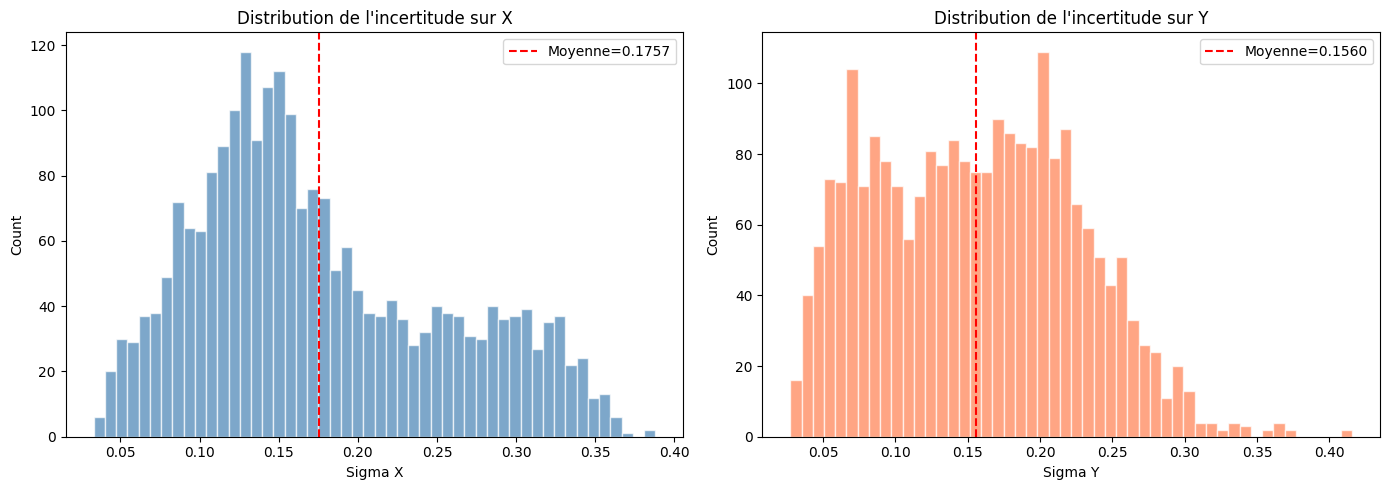

In [25]:
# --- Distribution des sigma ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_sigma[:, 0], bins=50, alpha=0.7, color='steelblue', edgecolor='white')
axes[0].axvline(y_sigma[:, 0].mean(), color='red', linestyle='--', label=f'Moyenne={y_sigma[:, 0].mean():.4f}')
axes[0].set_xlabel('Sigma X'); axes[0].set_ylabel('Count')
axes[0].set_title('Distribution de l\'incertitude sur X'); axes[0].legend()

axes[1].hist(y_sigma[:, 1], bins=50, alpha=0.7, color='coral', edgecolor='white')
axes[1].axvline(y_sigma[:, 1].mean(), color='red', linestyle='--', label=f'Moyenne={y_sigma[:, 1].mean():.4f}')
axes[1].set_xlabel('Sigma Y'); axes[1].set_ylabel('Count')
axes[1].set_title('Distribution de l\'incertitude sur Y'); axes[1].legend()

plt.tight_layout()
plt.show()

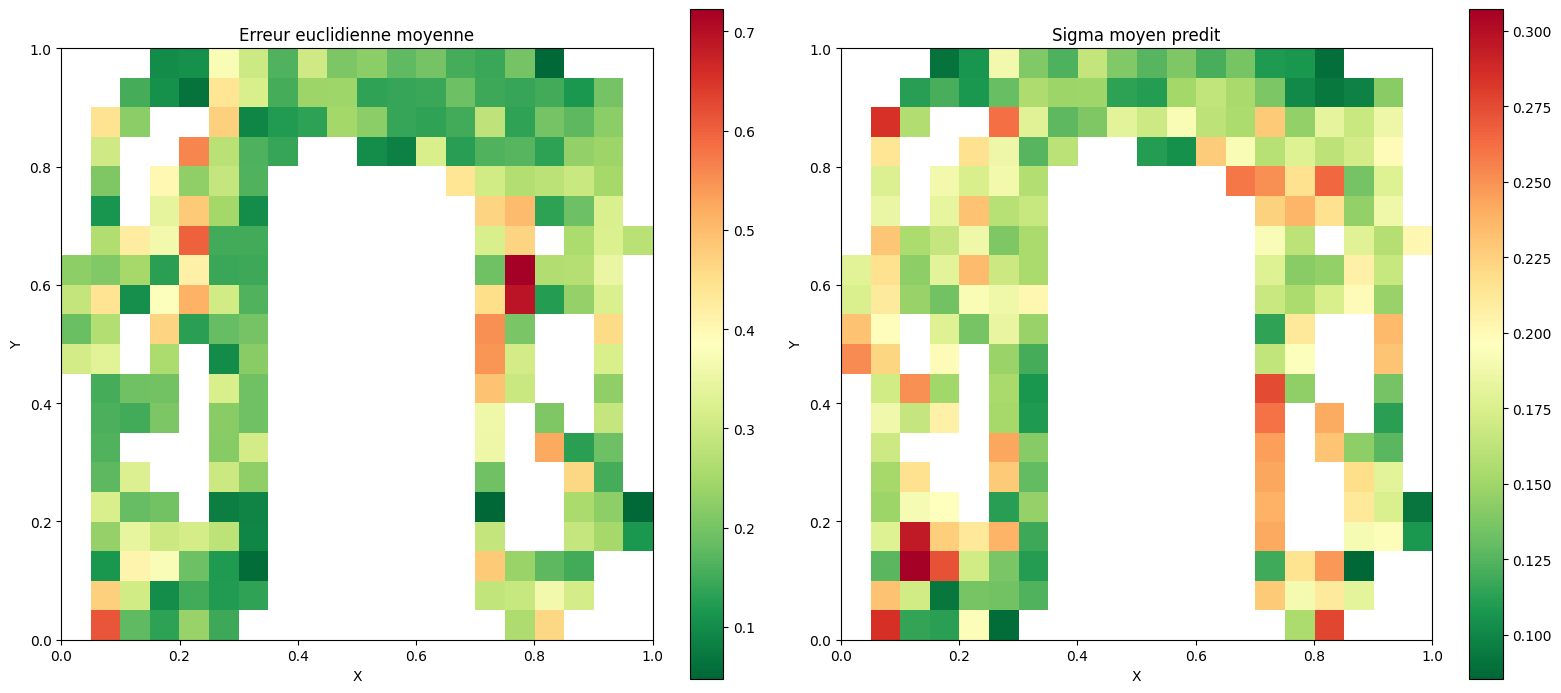

Corrélation de Spearman (sigma vs erreur) : 0.502 (p=4.14e-147)
  -> Bonne calibration : le modèle sait quand il se trompe


In [26]:
# --- Heatmap incertitude par position ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

nbins = 20
x_edges = np.linspace(0, 1, nbins + 1)
y_edges = np.linspace(0, 1, nbins + 1)

for ax_idx, (title, values) in enumerate([
    ('Erreur euclidienne moyenne', eucl_errors),
    ('Sigma moyen predit', (y_sigma[:, 0] + y_sigma[:, 1]) / 2)
]):
    val_map = np.full((nbins, nbins), np.nan)
    count_map = np.zeros((nbins, nbins))
    for i in range(len(y_test)):
        xi = np.clip(np.searchsorted(x_edges, y_test[i, 0]) - 1, 0, nbins - 1)
        yi = np.clip(np.searchsorted(y_edges, y_test[i, 1]) - 1, 0, nbins - 1)
        if np.isnan(val_map[yi, xi]):
            val_map[yi, xi] = 0
        val_map[yi, xi] += values[i]
        count_map[yi, xi] += 1
    mean_map = np.where(count_map > 0, val_map / count_map, np.nan)
    im = axes[ax_idx].imshow(mean_map, origin='lower', aspect='equal', cmap='RdYlGn_r', extent=[0, 1, 0, 1])
    axes[ax_idx].set_xlabel('X'); axes[ax_idx].set_ylabel('Y')
    axes[ax_idx].set_title(title)
    plt.colorbar(im, ax=axes[ax_idx])

plt.tight_layout()
plt.show()

corr, pval = spearmanr(sigma_mean, eucl_errors)
print(f'Corrélation de Spearman (sigma vs erreur) : {corr:.3f} (p={pval:.2e})')
print(f'  -> {"Bonne" if corr > 0.3 else "Faible"} calibration : le modèle {"sait" if corr > 0.3 else "ne sait pas bien"} quand il se trompe')

## 17. Sauvegarde des prédictions

In [27]:
np.save('../outputs/preds_transformer_02i.npy', y_pred)
np.save('../outputs/sigma_transformer_02i.npy', y_sigma)
np.save('../outputs/d_pred_transformer_02i.npy', d_pred_ensemble)
np.save('../outputs/y_test_transformer_02i.npy', y_test)
np.save('../outputs/d_test_transformer_02i.npy', d_test_targets)
np.save('../outputs/zone_pred_transformer_02i.npy', zone_pred)
np.save('../outputs/zone_test_transformer_02i.npy', zone_test_targets)
np.save('../outputs/probs_transformer_02i.npy', probs_ensemble)

print(f'Prédictions sauvegardées :')
print(f'  preds_transformer_02i.npy : {y_pred.shape}')
print(f'  sigma_transformer_02i.npy : {y_sigma.shape}')
print(f'  d_pred_transformer_02i.npy : {d_pred_ensemble.shape}')
print(f'  zone_pred_transformer_02i.npy : {zone_pred.shape}')
print(f'  probs_transformer_02i.npy : {probs_ensemble.shape}')

Prédictions sauvegardées :
  preds_transformer_02i.npy : (2298, 2)
  sigma_transformer_02i.npy : (2298, 2)
  d_pred_transformer_02i.npy : (2298,)
  zone_pred_transformer_02i.npy : (2298,)
  probs_transformer_02i.npy : (2298, 3)


## 18. Interprétation

### Ce notebook combine toutes les améliorations

**1. Spike dropout (15%) + Bruit gaussien (std=0.5)**
- Régularisation par data augmentation : le modèle voit des variantes bruitées de chaque séquence
- Force le modèle à utiliser le population coding (redondance entre neurones) plutôt que de dépendre d'un seul spike
- L'effet se mesure par la variance inter-folds : plus stable = meilleure généralisation

**2. Feasibility loss (λ=10.0)**
- Incorpore la connaissance du domaine (géométrie du U-maze) directement dans la loss
- Pénalise quadratiquement les prédictions hors couloir
- L'effet se mesure par le % de prédictions hors labyrinthe et la distance moyenne au squelette

**3. Classification hiérarchique 3 zones**
- Exploite la structure du labyrinthe : gauche / haut / droite
- Mélange d'experts : chaque zone a son propre head de régression spécialisé
- L'incertitude aux transitions est naturellement plus élevée (mélange multimodal)
- L'effet se mesure par la matrice de confusion et l'erreur par zone

**4. 5-fold cross-validation (30 epochs)**
- 5 modèles indépendants → ensemble robuste
- Incertitude épistémique (variance entre folds) + aléatoire (sigma prédits)
- Early stopping avec patience=7 pour éviter l'overfitting

### Métriques clés à comparer avec les notebooks précédents
- **Erreur euclidienne** : plus basse = meilleure précision
- **R²** : plus proche de 1 = meilleur
- **% hors labyrinthe** : plus bas = feasibility loss fonctionne
- **Accuracy zone** : classification correcte
- **Calibration** : sigma corrélé avec erreur = le modèle sait quand il se trompe